In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configurar directorio

import os

carpeta = '/content/drive/My Drive/UTEC/2024_2/PFC/metropolitano'

os.chdir(carpeta)

print("Directorio de trabajo actual:", os.getcwd())


Directorio de trabajo actual: /content/drive/My Drive/UTEC/2024_2/PFC/metropolitano


In [ ]:
# Comprobar si es correcto
archivos = os.listdir('.')
print("Archivos en el directorio de trabajo:")
for archivo in archivos:
    print(archivo)


Archivos en el directorio de trabajo:
data.xlsx
scaler.pkl
matrices_normalizadas
autoencoder_best_v03.keras


In [ ]:
# Librerías
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
data_folder = './matrices_normalizadas'

files = os.listdir(data_folder)

# Gamma_i_{day}.csv
gamma_files = [f for f in files if f.startswith('matriz_') and f.endswith('.csv')]

# ordenar por fecha
gamma_files_sorted = sorted(gamma_files, key=lambda x: pd.to_datetime(x.split('_')[1].split('.csv')[0]))

gamma_matrices = []

dates = []

for file in gamma_files_sorted:
    file_path = os.path.join(data_folder, file)
    matrix = pd.read_csv(file_path, index_col=0).values
    gamma_matrices.append(matrix)

    # Extraer la fecha del nombre del archivo
    date_str = file.split('_')[1].split('.csv')[0]
    dates.append(pd.to_datetime(date_str))

gamma_matrices = np.array(gamma_matrices)  # Shape: (num_days, M, N)
dates = np.array(dates)

print(f"Total de días cargados: {gamma_matrices.shape[0]}")
print(f"Dimensiones de cada matriz: {gamma_matrices.shape[1]}x{gamma_matrices.shape[2]}")


Total de días cargados: 182
Dimensiones de cada matriz: 24x44


In [ ]:
# Proporciones para los conjuntos
train_size = 0.7  # 70% para entrenamiento
val_size = 0.2    # 20% para validación
test_size = 0.1   # 10% para prueba

# Total de días
num_days = gamma_matrices.shape[0]

# Calcular índices de corte
train_days = int(num_days * train_size)
val_days = int(num_days * val_size)

# Dividir los datos
X_train = gamma_matrices[:train_days]
X_val = gamma_matrices[train_days:train_days + val_days]
X_test = gamma_matrices[train_days + val_days:-1]

y_train = gamma_matrices[1:train_days + 1]
y_val = gamma_matrices[train_days + 1:train_days + val_days + 1]
y_test = gamma_matrices[train_days + val_days + 1:]

# Imprimir tamaños de cada conjunto
print(f"Días de entrenamiento: {X_train.shape[0]}")
print(f"Días de validación: {X_val.shape[0]}")
print(f"Días de prueba: {X_test.shape[0]}")


Días de entrenamiento: 127
Días de validación: 36
Días de prueba: 18


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense
from tensorflow.keras.optimizers import Adam

M = 24
N = 44

# Definir dimensiones de entrada
input_shape = (M, N, 1)  # Asumimos una entrada con 1 canal (puedes ajustar esto si tienes más canales)

# Entrada
input_layer = Input(shape=input_shape)

# Encoder (CNN + LSTM)
conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)  # Convolución 2D
conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv1)      # Otra convolución 2D
pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)                                   # Max Pooling 2D
flatten = Flatten()(pool1)                                                                     # Aplanar

# LSTM
reshape = Reshape((M // 2, N // 2 * 128))(flatten)  # Ajustar la forma antes de pasar a LSTM
lstm1 = LSTM(128, activation='tanh', return_sequences=True)(reshape)
lstm2 = LSTM(64, activation='tanh', return_sequences=False)(lstm1)

# Bottleneck (representación latente)
bottleneck = Dense(32, activation='relu')(lstm2)

# Decoder (Predicción del día x+1)
predicted_output = Dense(M * N, activation='linear')(bottleneck)
output_layer = Reshape((M, N))(predicted_output)  # Formato matriz

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

# Compilar
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Resumen
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24, 44, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 44, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 33792)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 12, 2816)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 12, 128)             │       1,507,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1056)                │          34,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 24, 44)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,668,672 (6.37 MB)

 Trainable params: 1,668,672 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Preparar los datos para el modelo
X_train_reshaped = X_train
y_train_reshaped = X_train.copy()

X_val_reshaped = X_val
y_val_reshaped = X_val.copy()

# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('autoencoder_best_v03.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(
    X_train_reshaped,
    y_train_reshaped,
    epochs=1000,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_reshaped, y_val_reshaped),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0757 - val_loss: 0.0762
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - loss: 0.0705 - val_loss: 0.0628
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - loss: 0.0564 - val_loss: 0.0453
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 979ms/step - loss: 0.0396 - val_loss: 0.0290
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 771ms/step - loss: 0.0251 - val_loss: 0.0181
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step - loss: 0.0154 - val_loss: 0.0118
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - loss: 0.0104 - val_loss: 0.0084
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 967ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 591ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 927ms/step -

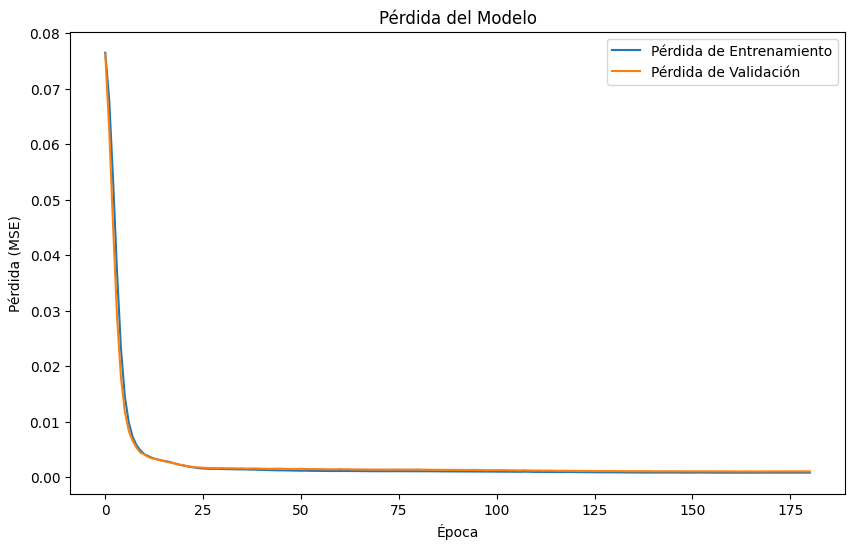

In [ ]:
# Graficar
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
Dimensiones de la salida (y_pred): (18, 24, 44)


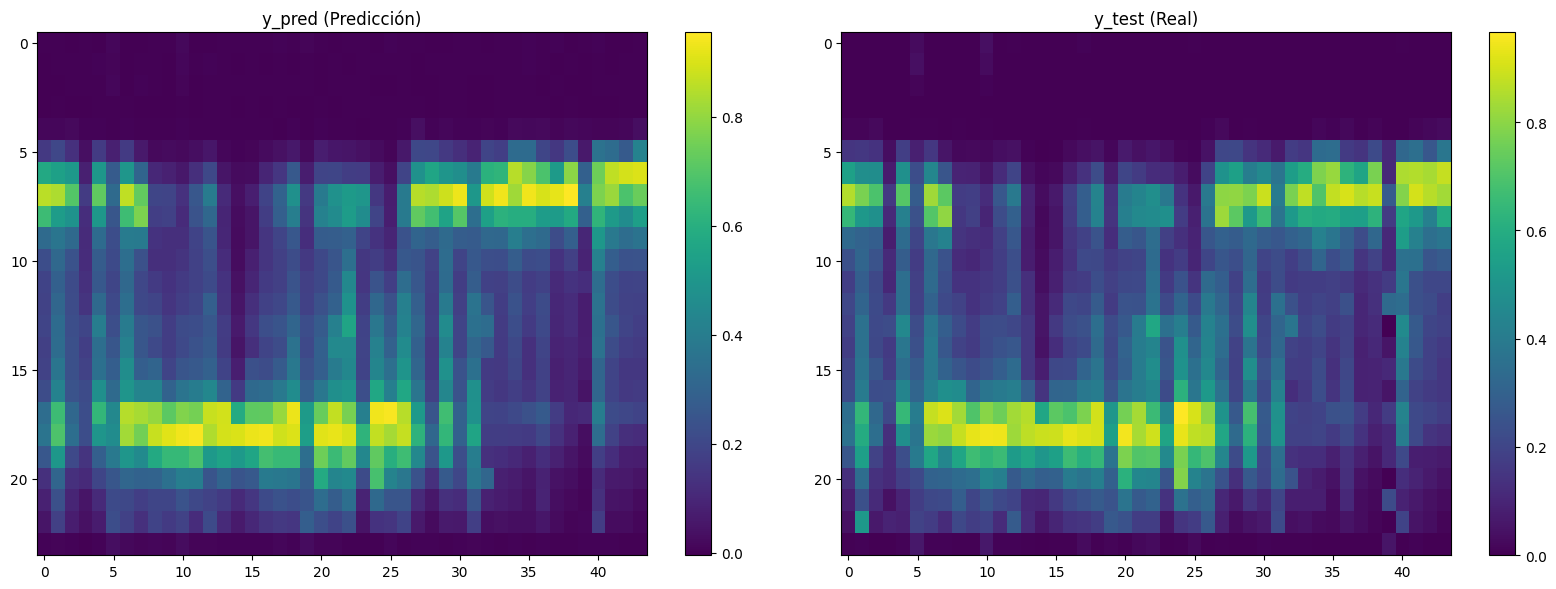

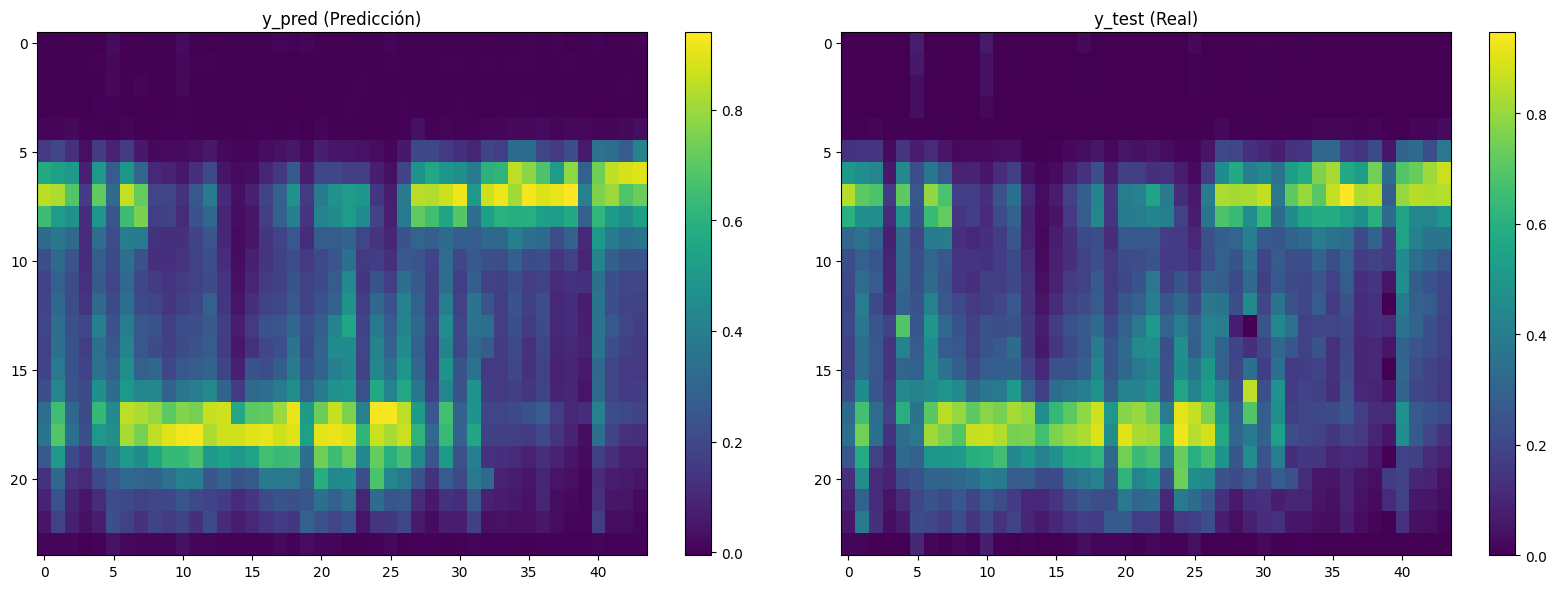

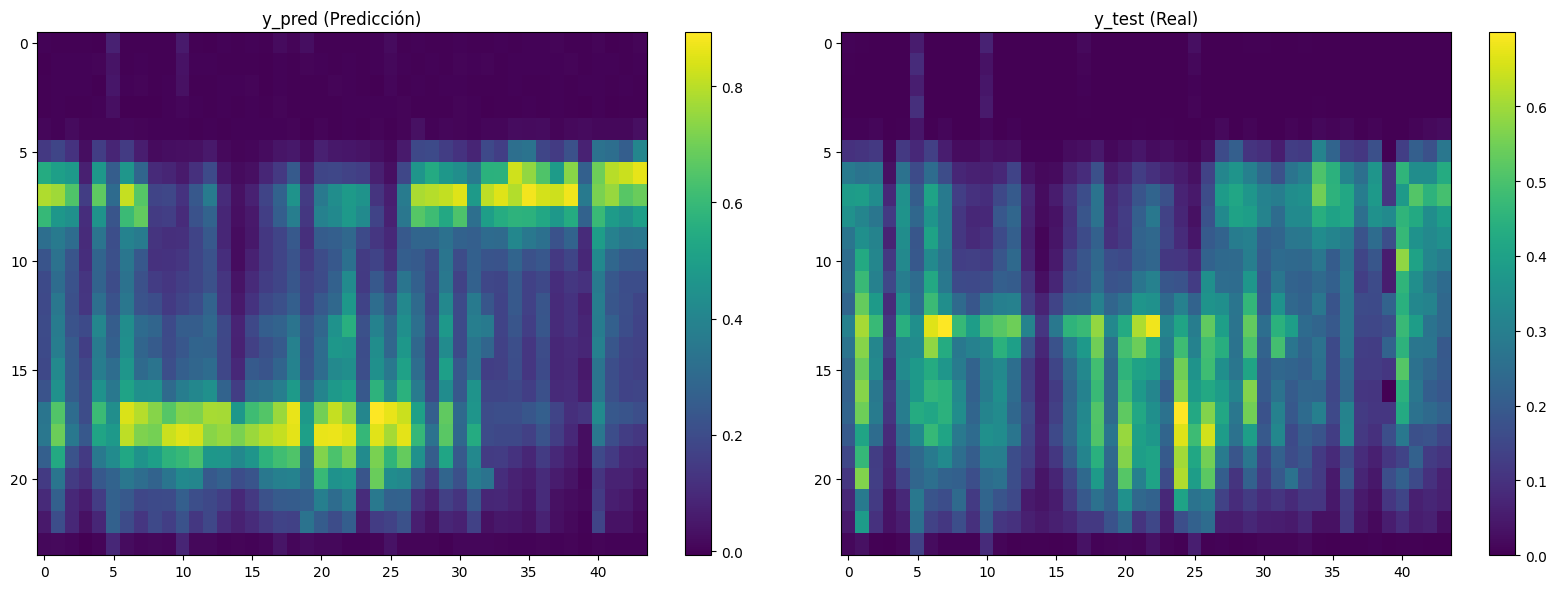

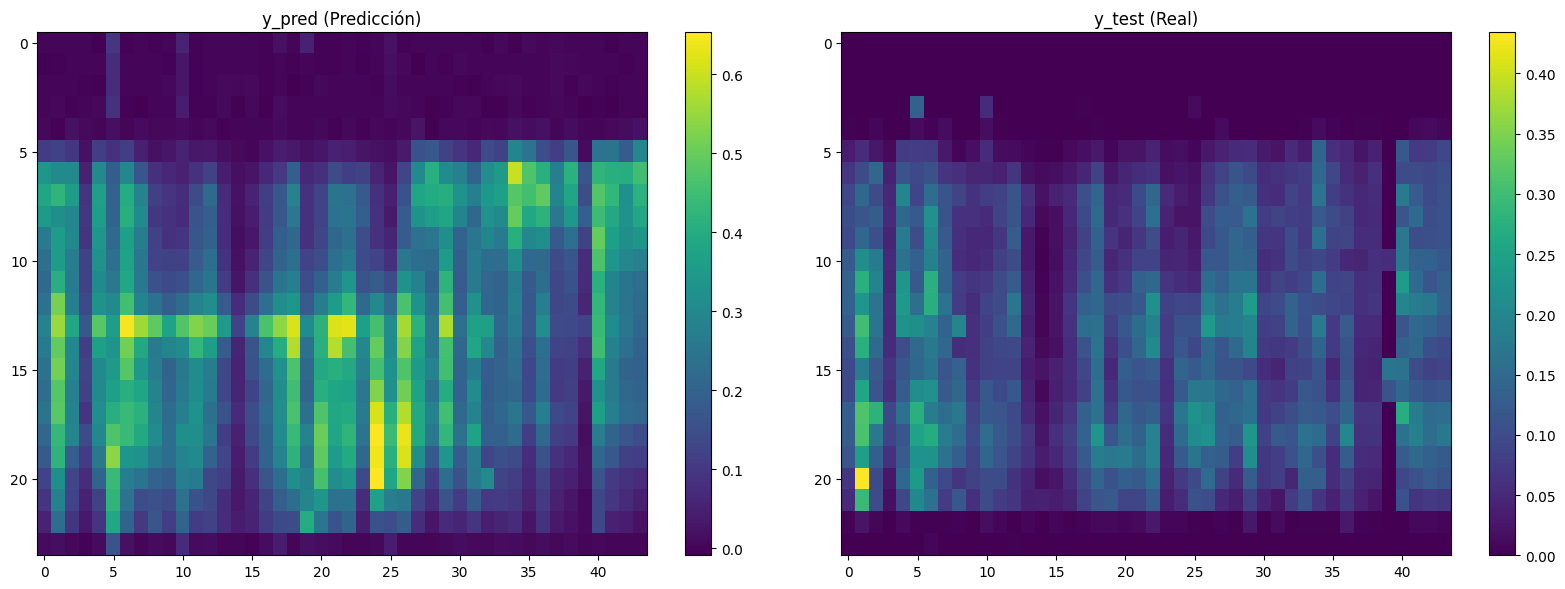

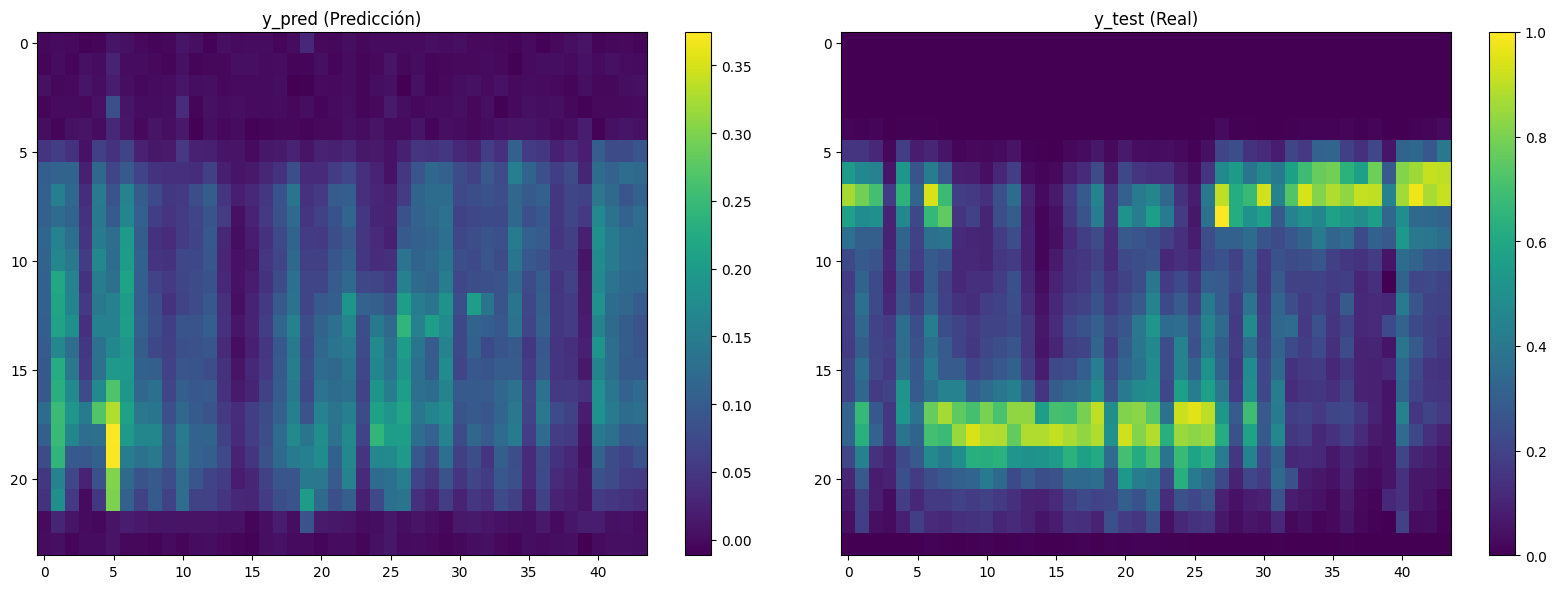

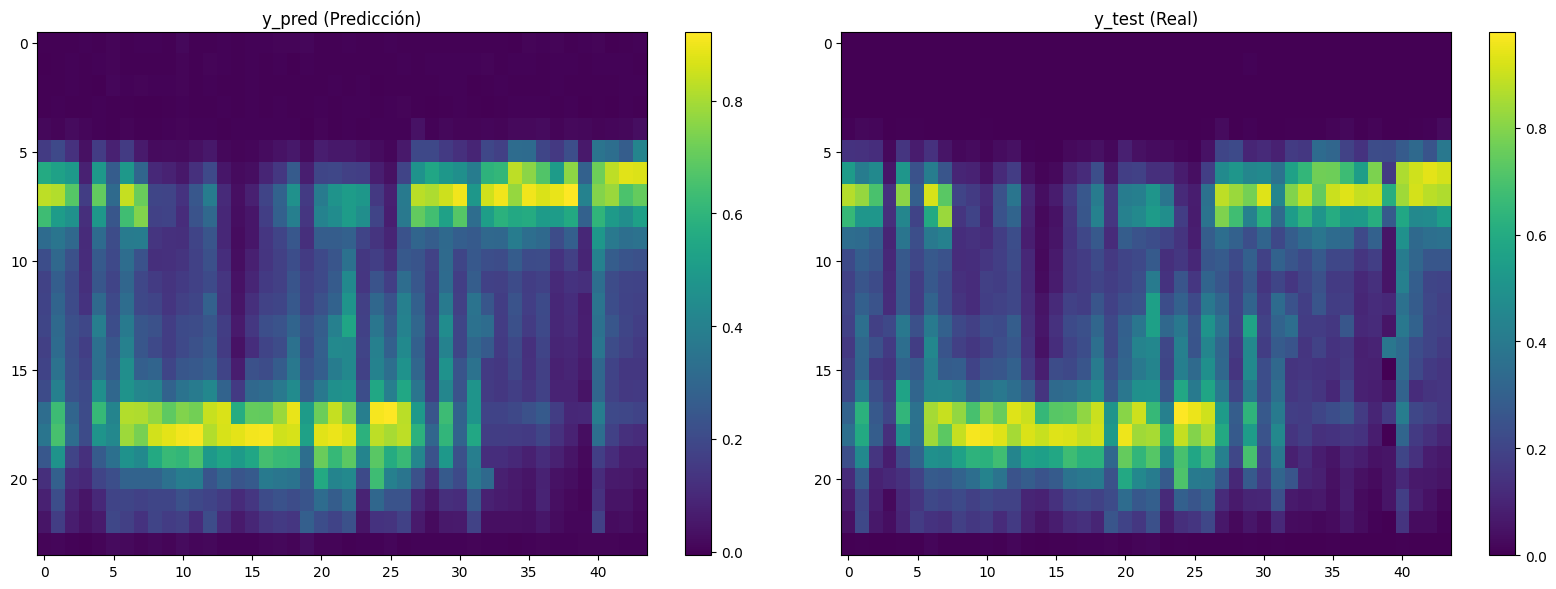

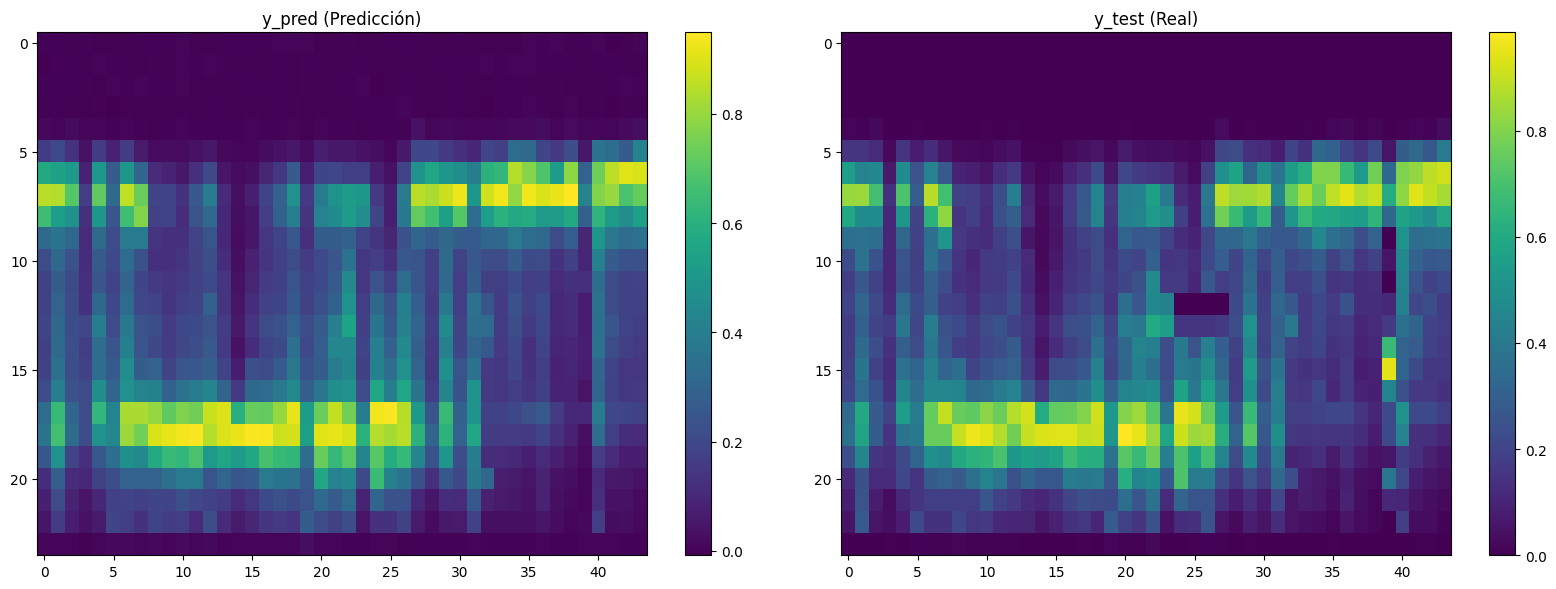

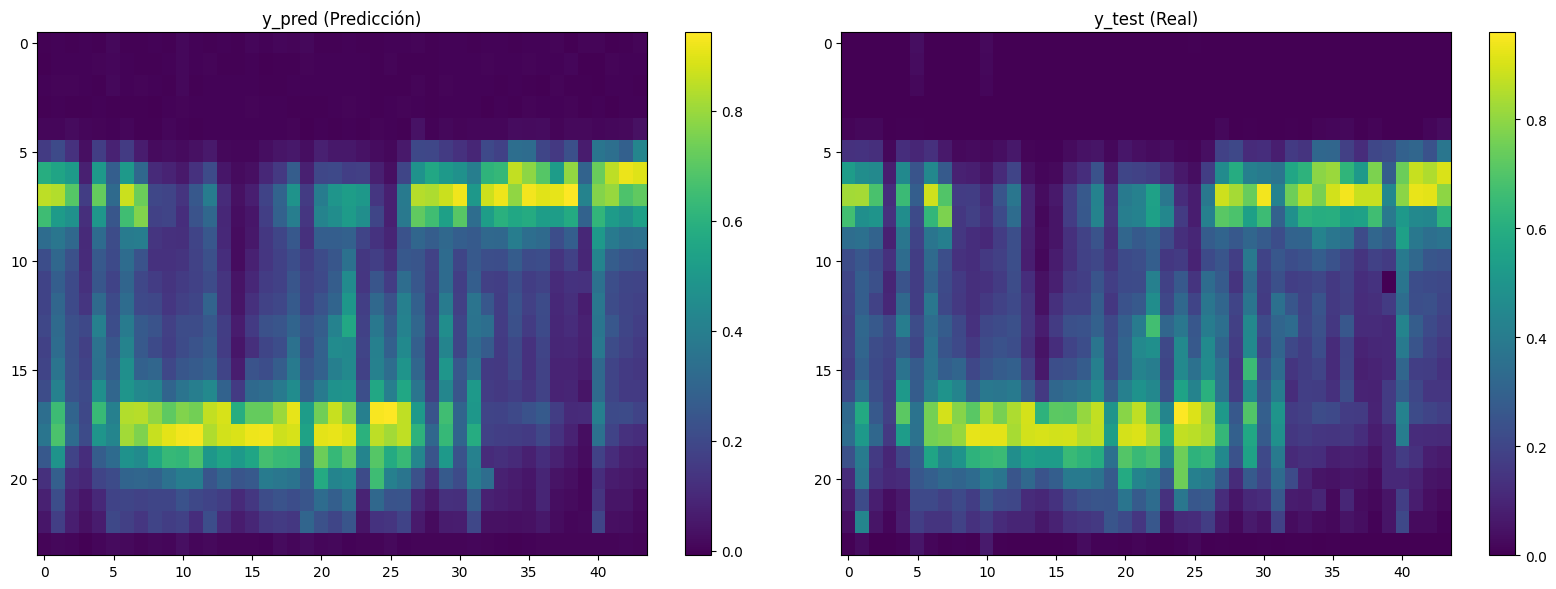

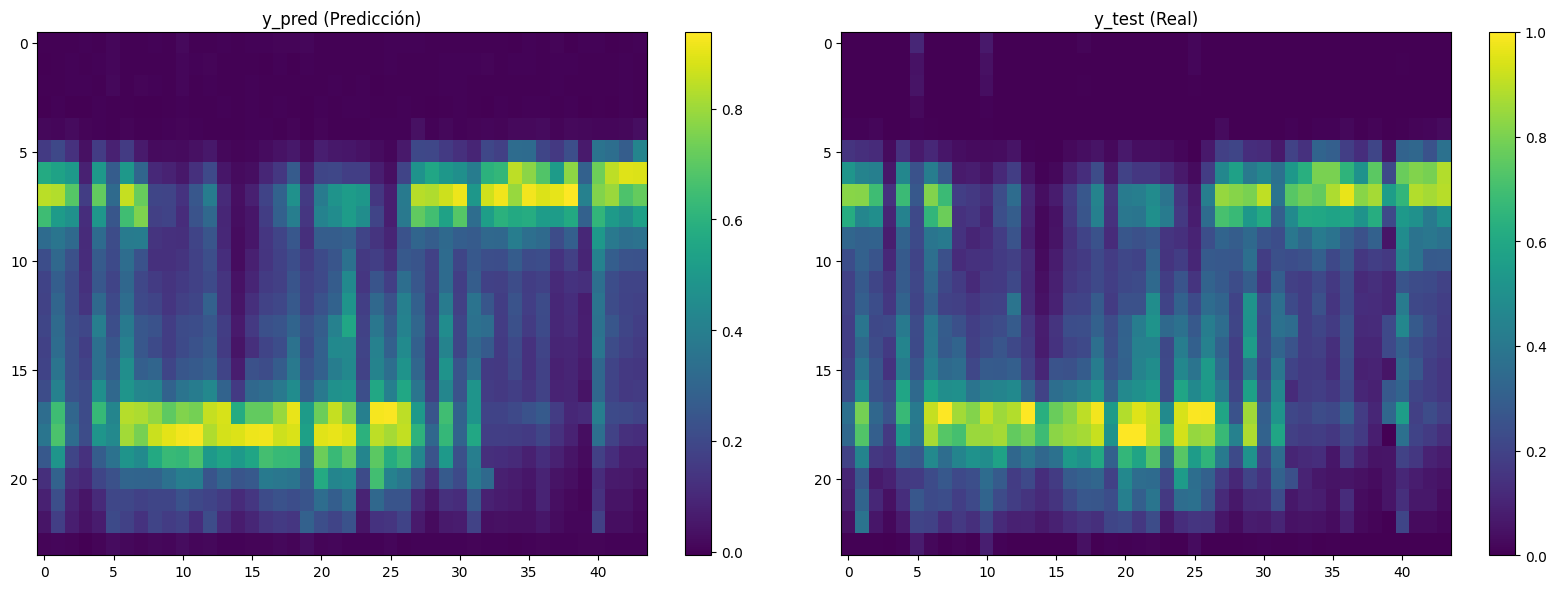

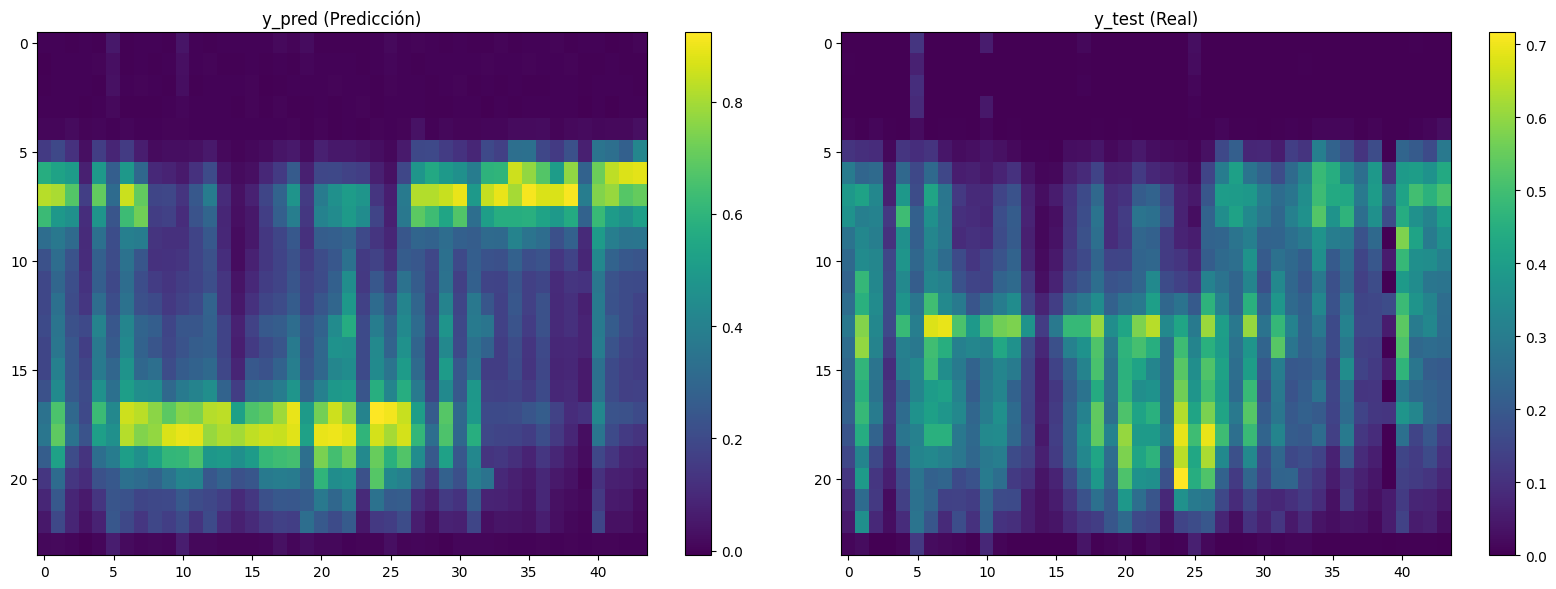

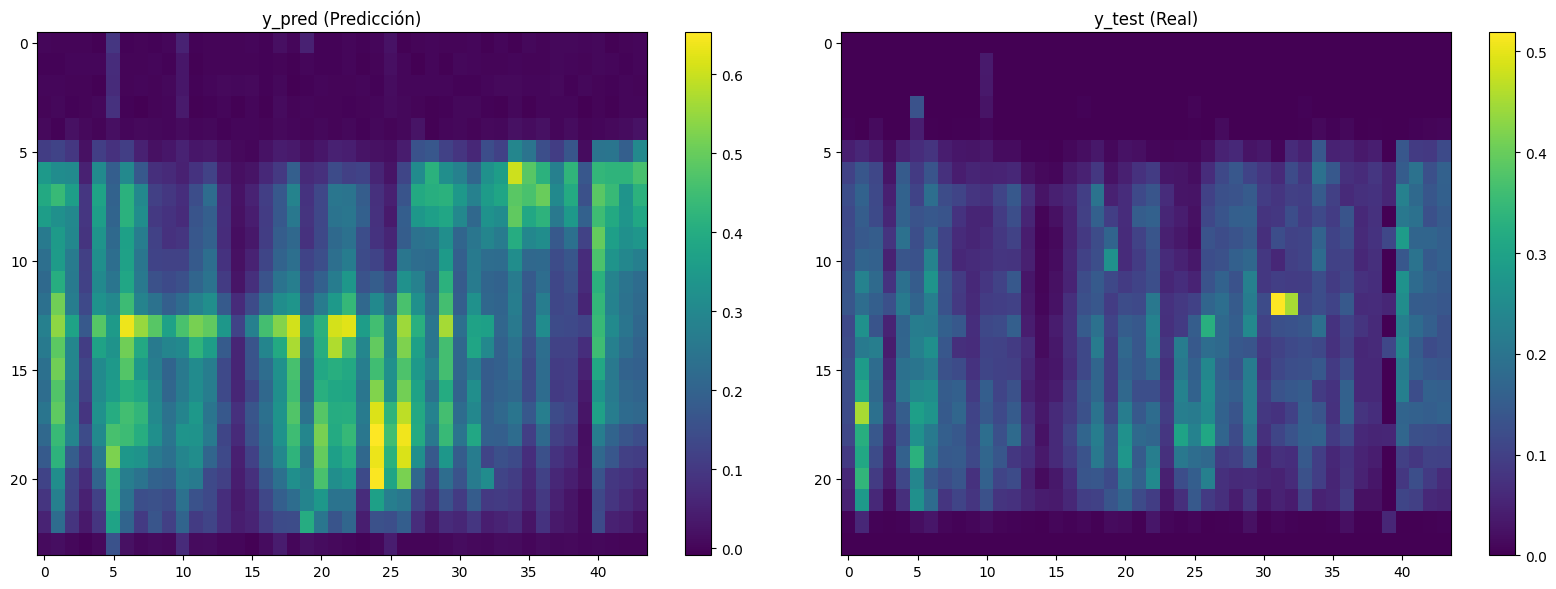

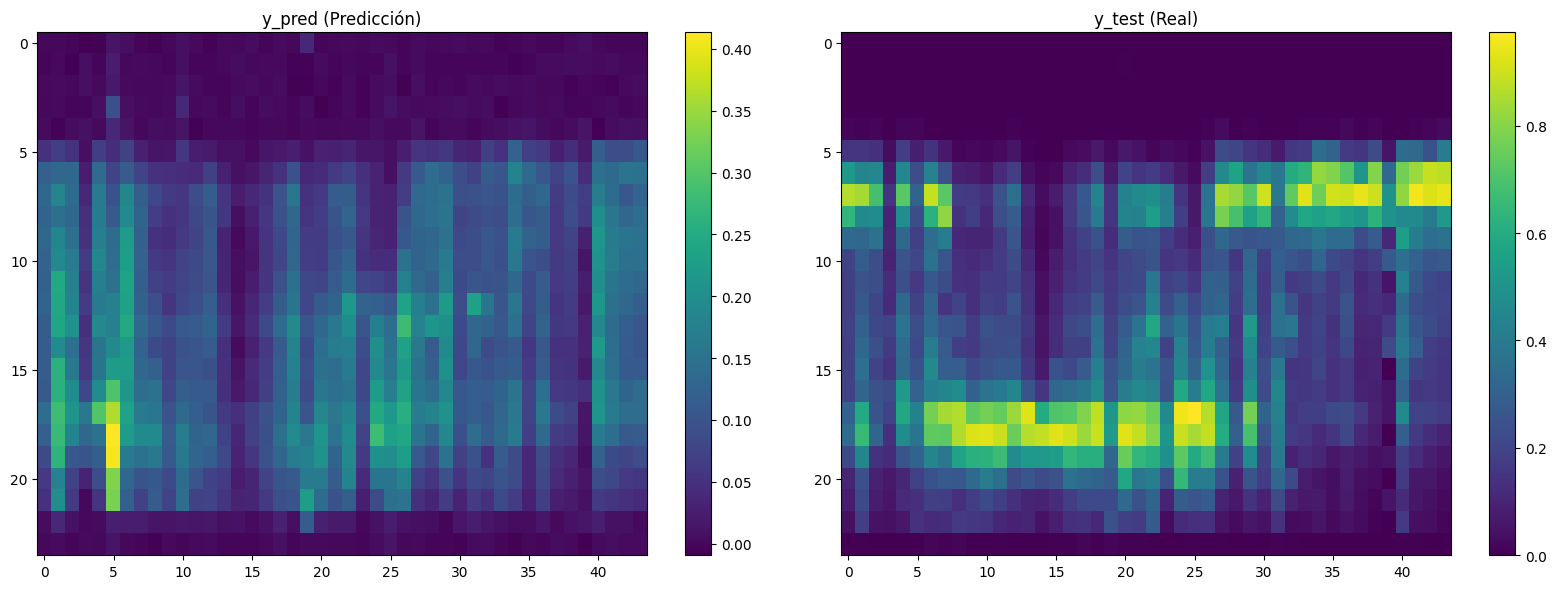

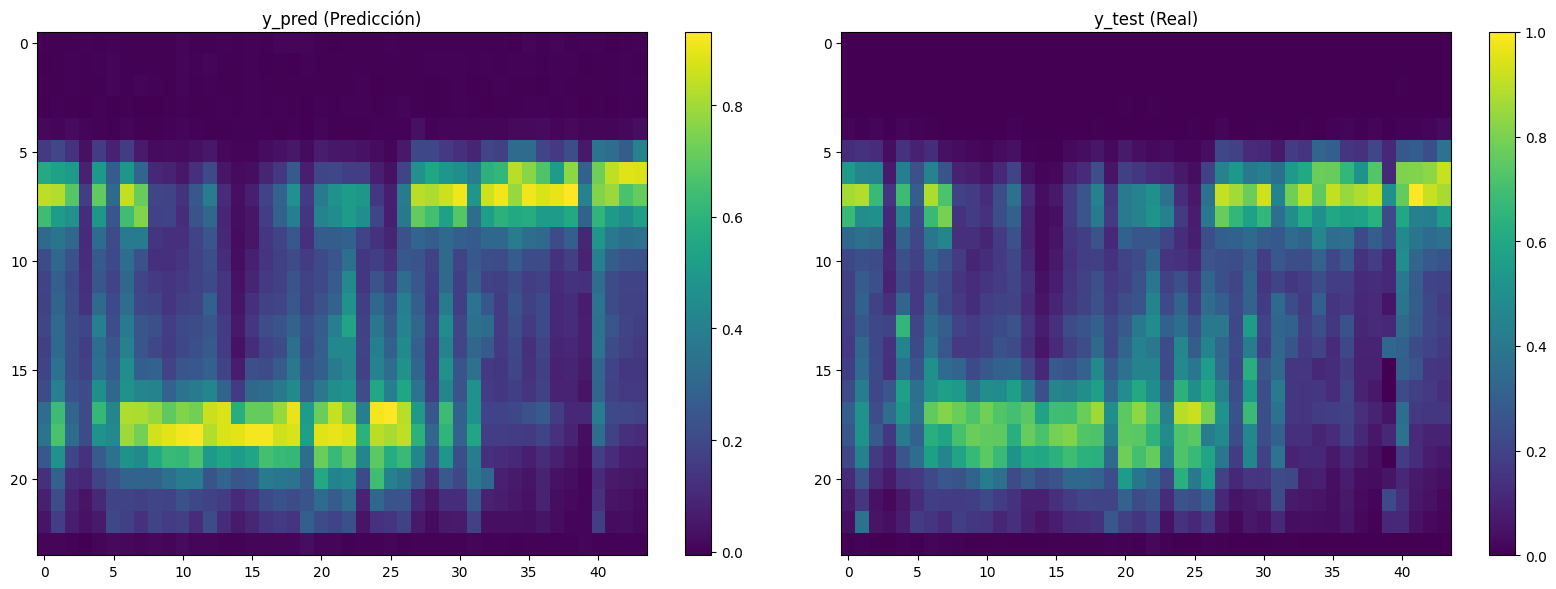

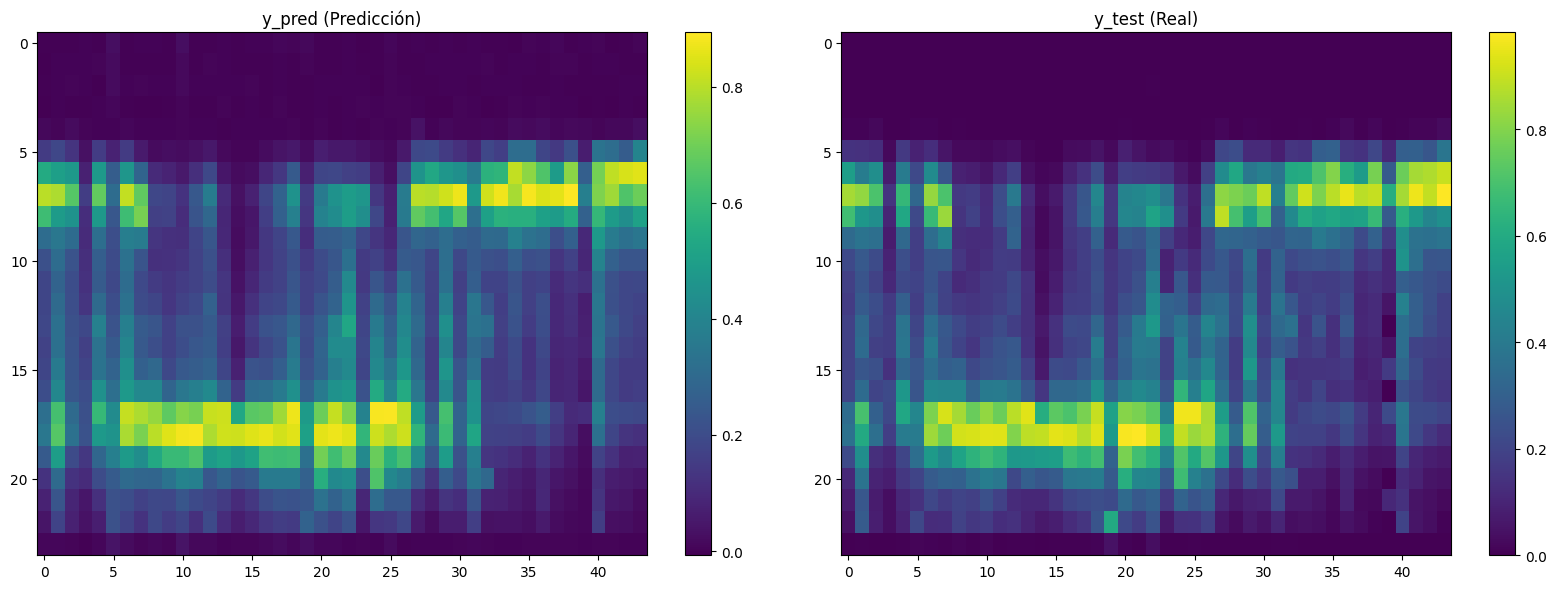

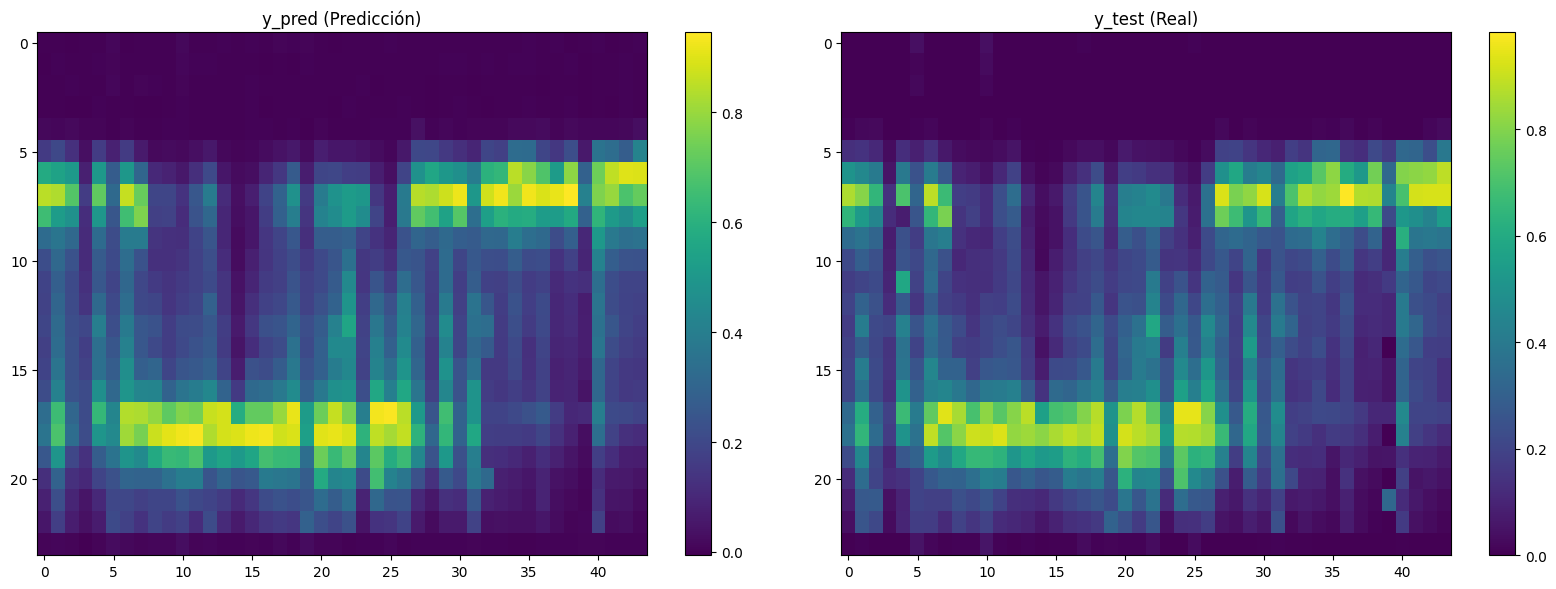

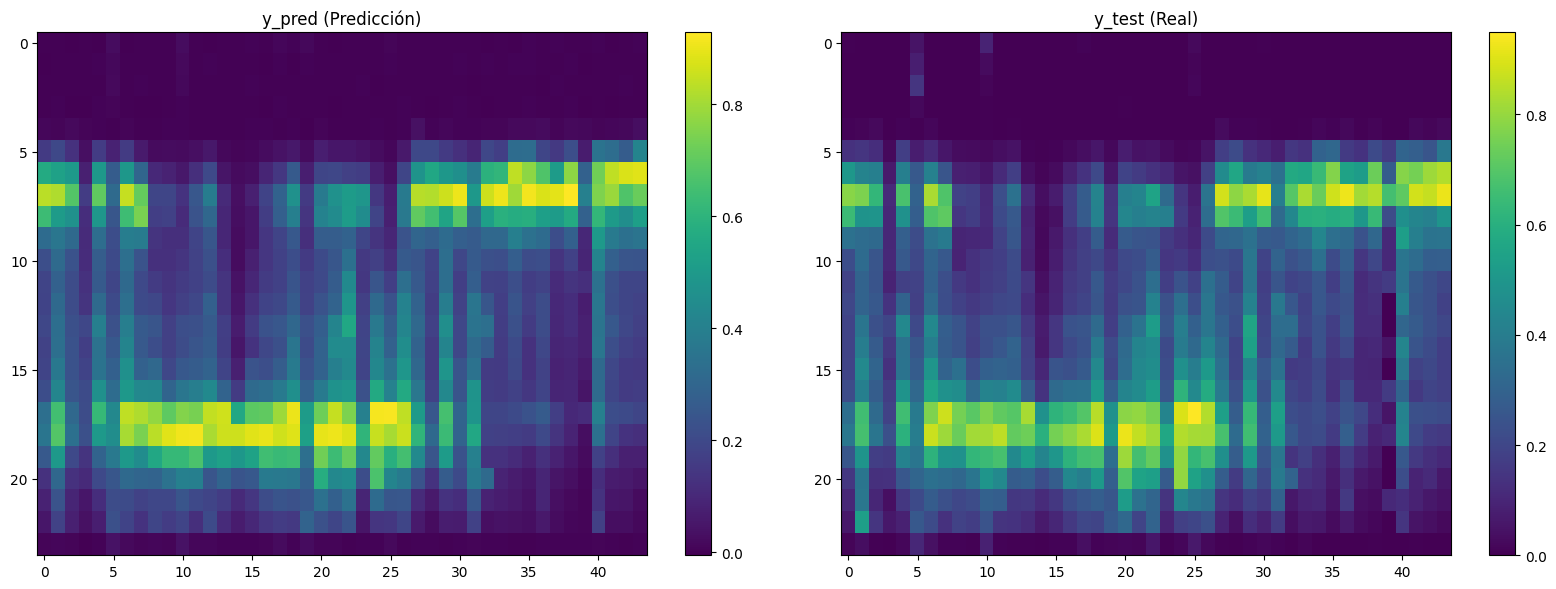

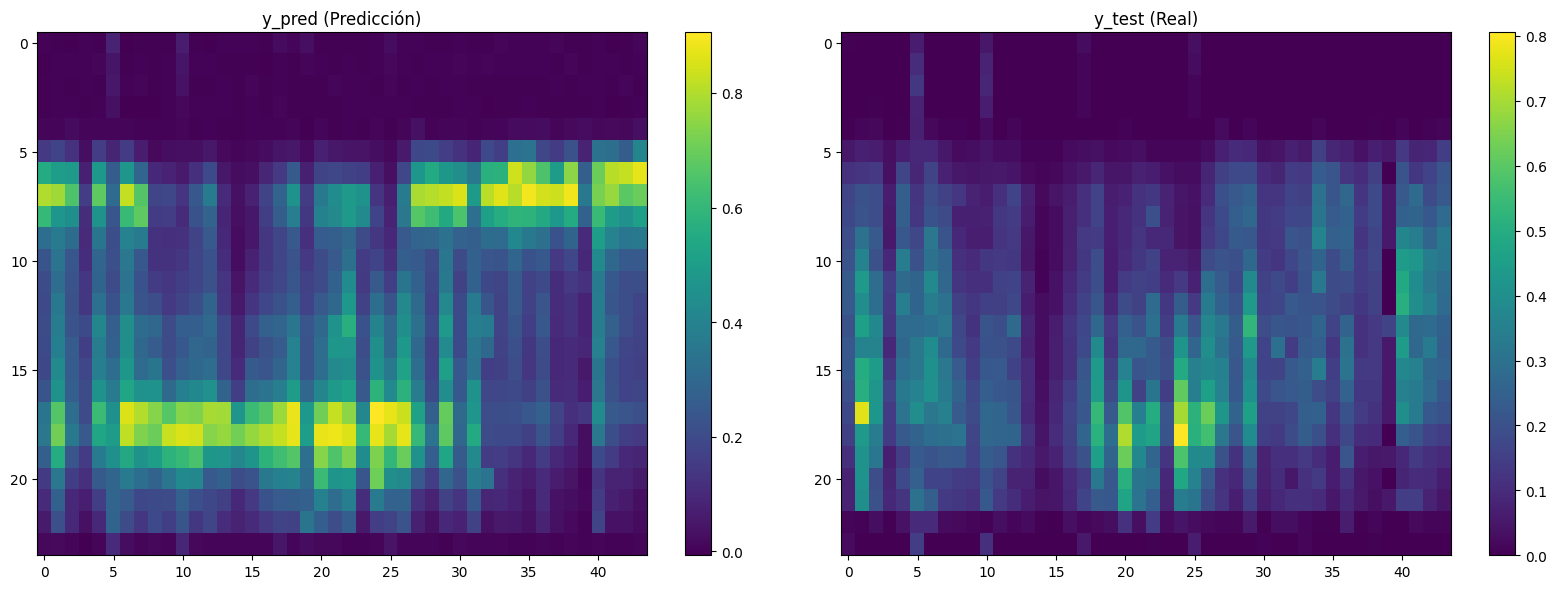

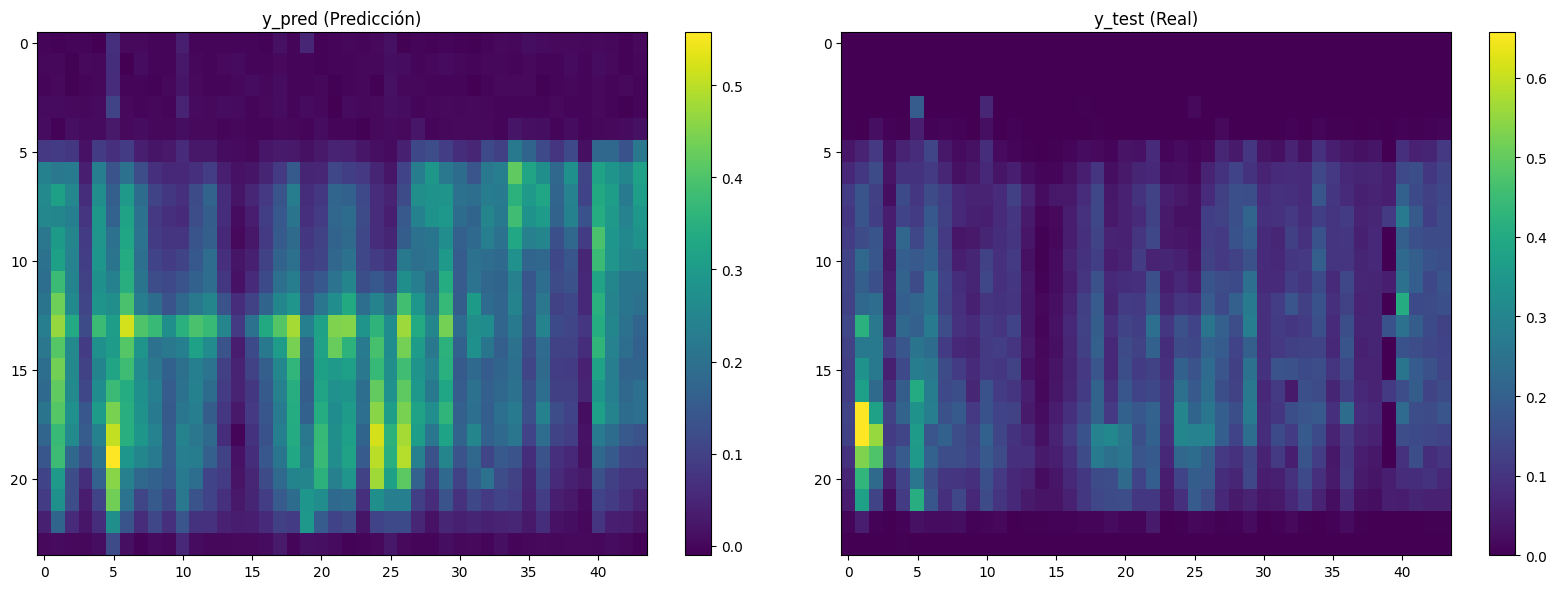

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de las matrices
M, N = 22, 44

# Cargar el modelo
autoencoder = load_model('autoencoder_best_v03.keras')

# Seleccionar ejemplos
num_examples = 18

# Validar las dimensiones de X_test y y_test
if X_test.ndim == 2 and X_test.shape[1] == M * N:
    X_example = X_test[:num_examples].reshape(num_examples, M, N)
    y_example = y_test[:num_examples].reshape(num_examples, M, N)
else:
    X_example = X_test[:num_examples]
    y_example = y_test[:num_examples]

# Predicción
y_pred = autoencoder.predict(X_example)

# Verificar dimensiones de la salida
print("Dimensiones de la salida (y_pred):", y_pred.shape)

# Visualización
for i in range(num_examples):
    plt.figure(figsize=(24, 6))


    # Predicción
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred[i], cmap='viridis', aspect='auto')
    plt.title('y_pred (Predicción)')
    plt.colorbar()

    # Real
    plt.subplot(1, 3, 3)
    plt.imshow(y_example[i], cmap='viridis', aspect='auto')
    plt.title('y_test (Real)')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


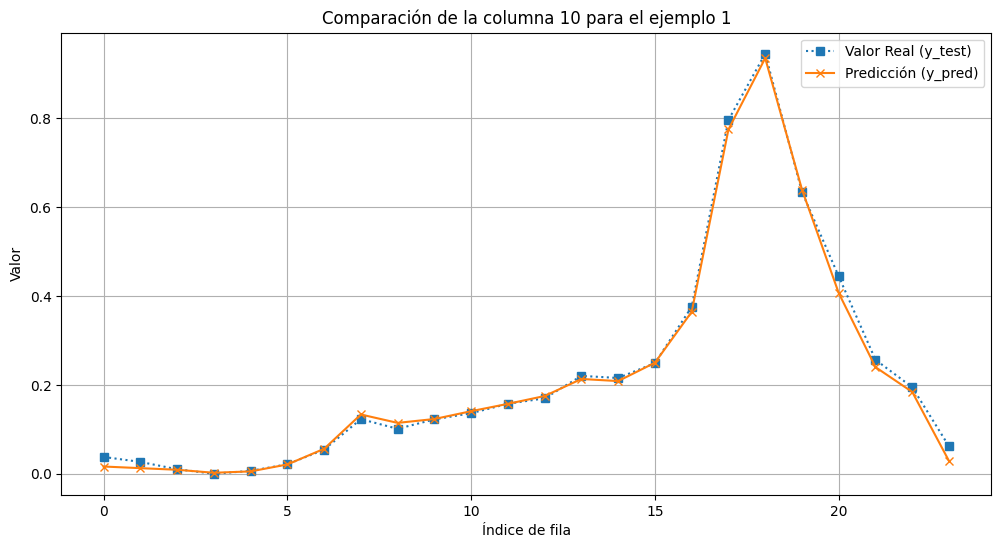

Ejemplo 1 - MAE: 0.0099, MSE: 0.0002


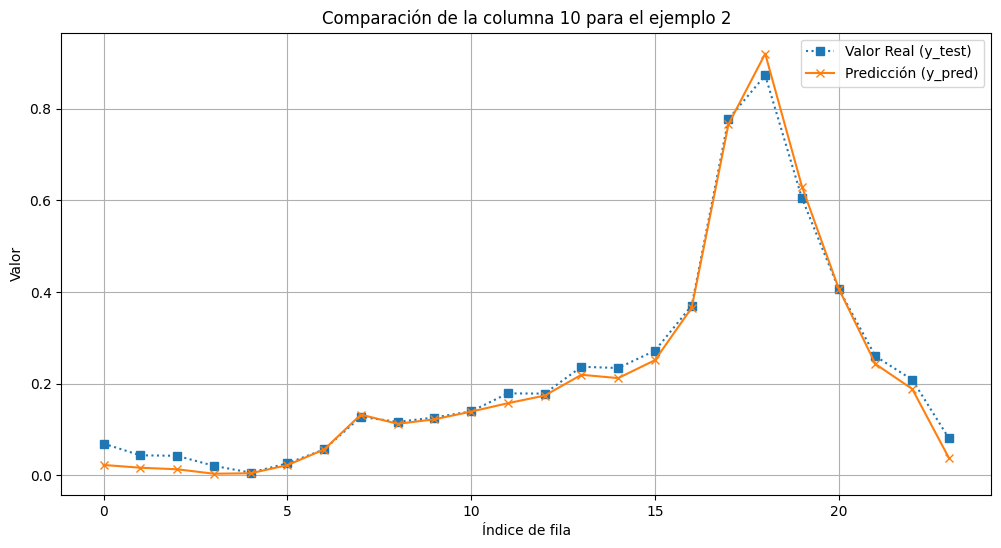

Ejemplo 2 - MAE: 0.0165, MSE: 0.0005


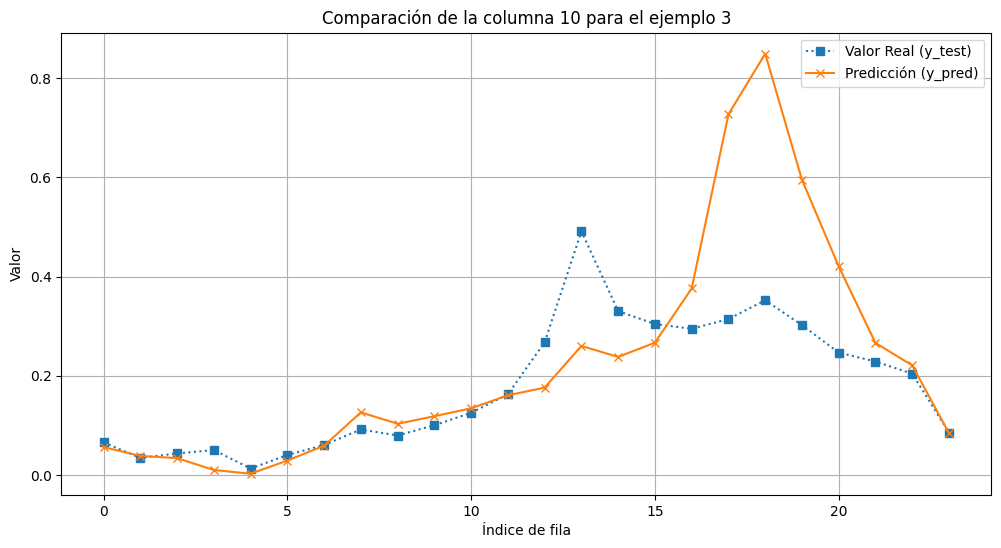

Ejemplo 3 - MAE: 0.0891, MSE: 0.0257


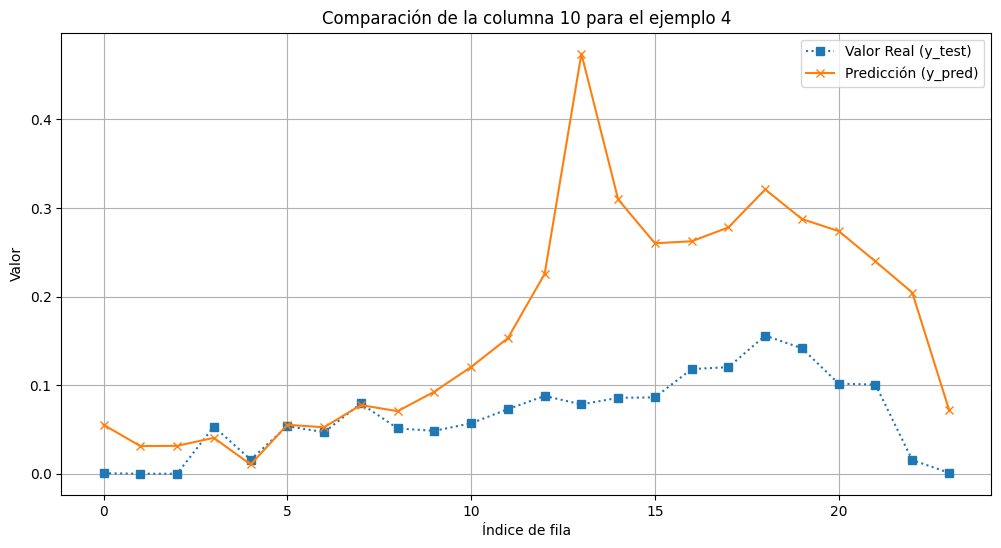

Ejemplo 4 - MAE: 0.1028, MSE: 0.0191


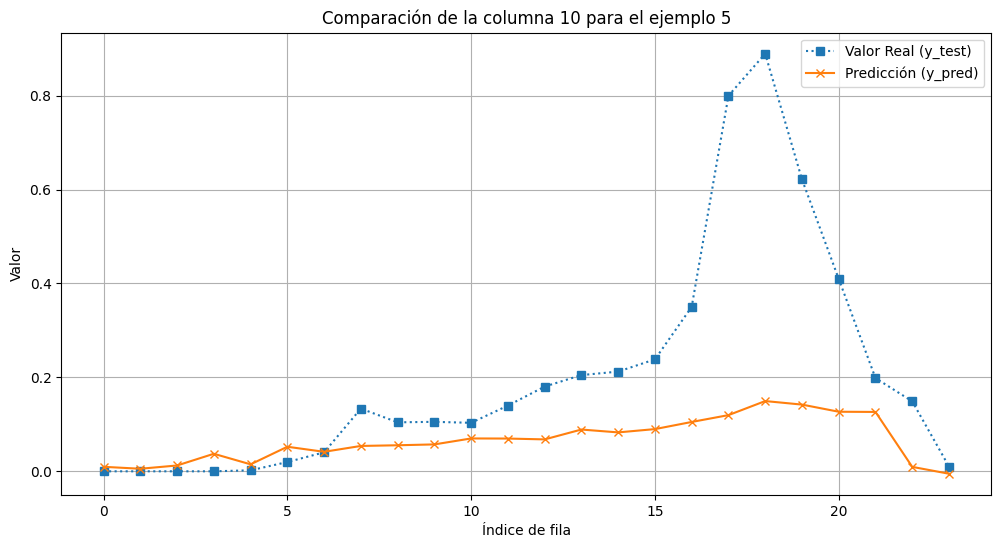

Ejemplo 5 - MAE: 0.1480, MSE: 0.0621


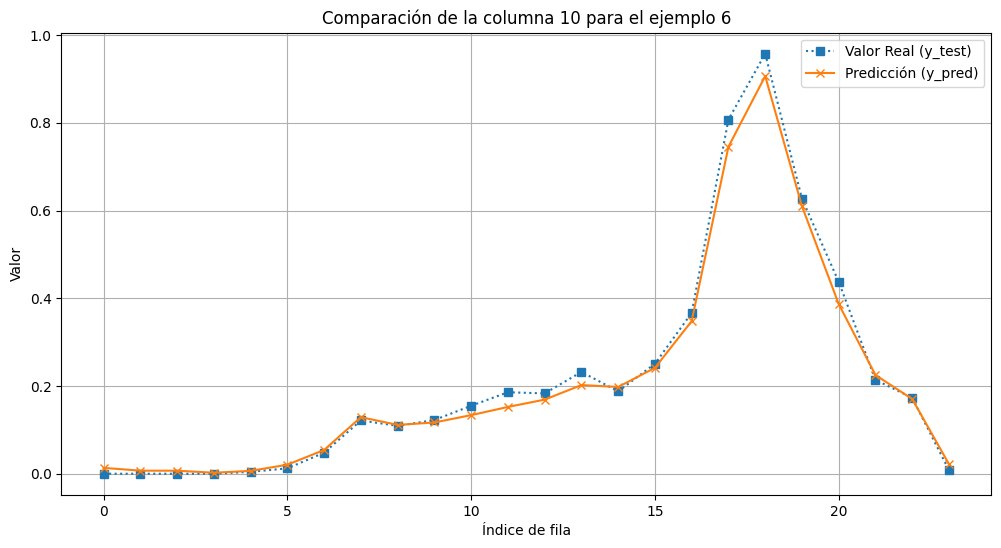

Ejemplo 6 - MAE: 0.0169, MSE: 0.0006


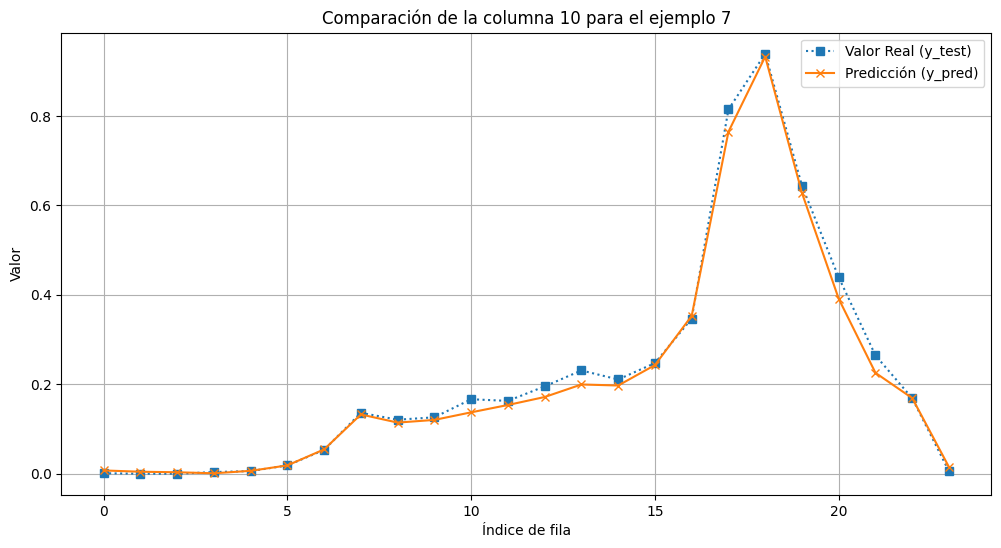

Ejemplo 7 - MAE: 0.0134, MSE: 0.0004


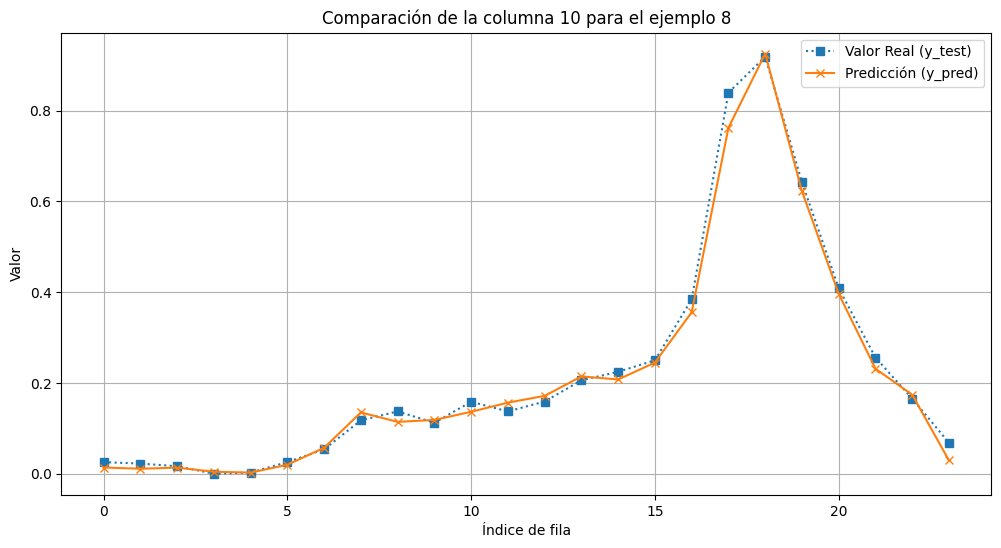

Ejemplo 8 - MAE: 0.0161, MSE: 0.0005


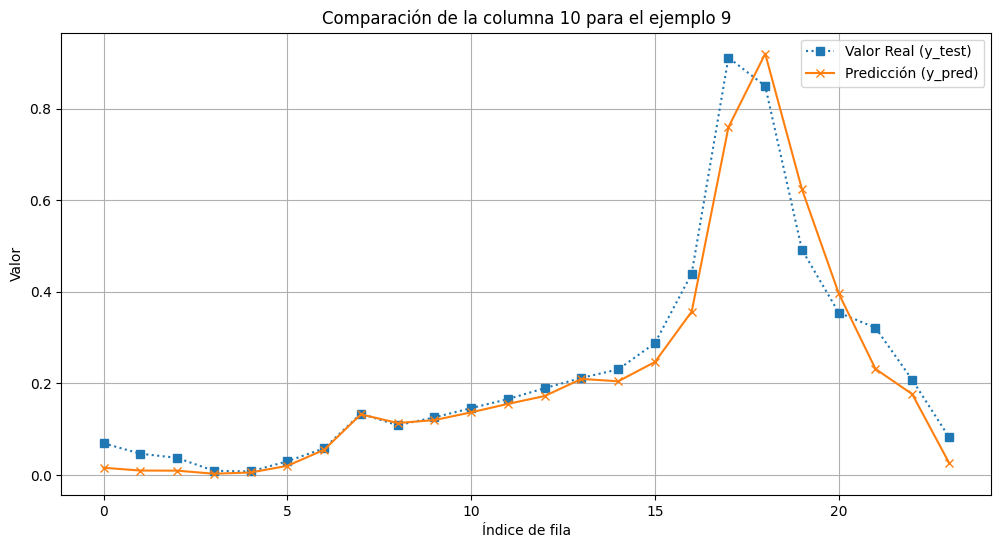

Ejemplo 9 - MAE: 0.0381, MSE: 0.0031


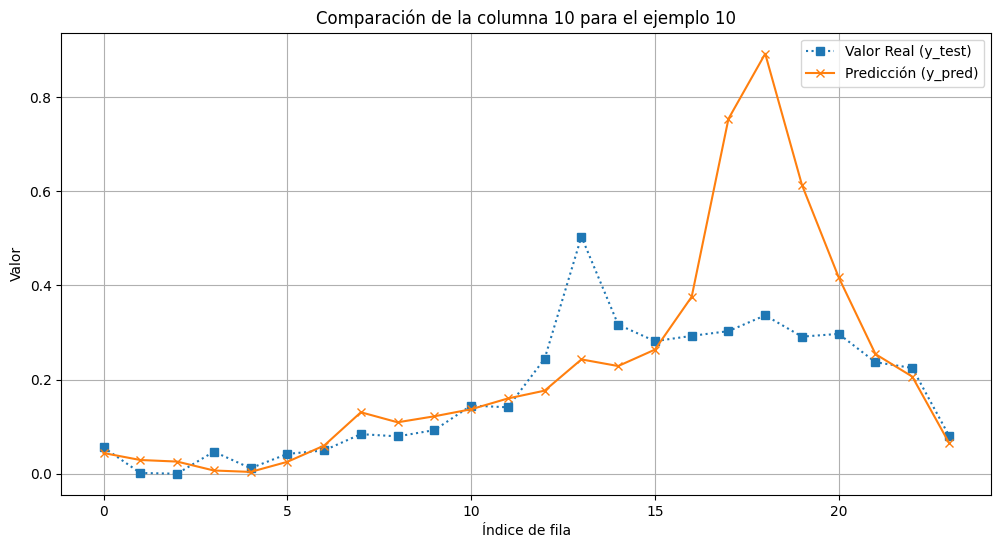

Ejemplo 10 - MAE: 0.0954, MSE: 0.0303


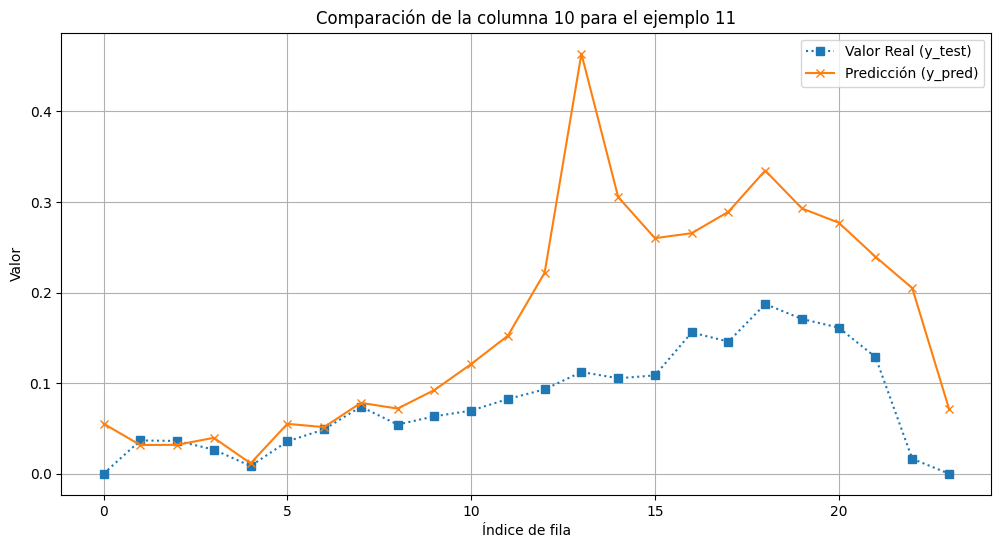

Ejemplo 11 - MAE: 0.0881, MSE: 0.0146


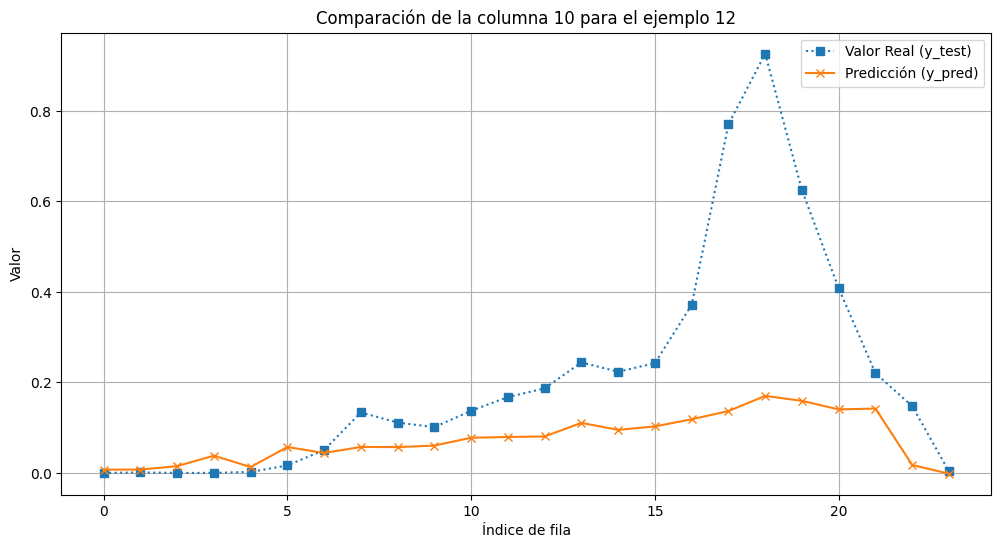

Ejemplo 12 - MAE: 0.1475, MSE: 0.0600


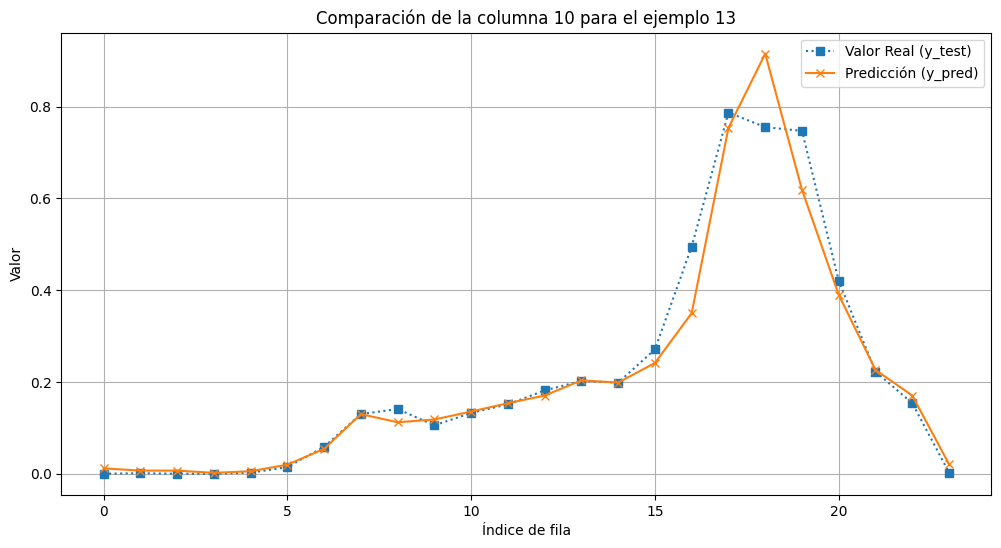

Ejemplo 13 - MAE: 0.0277, MSE: 0.0028


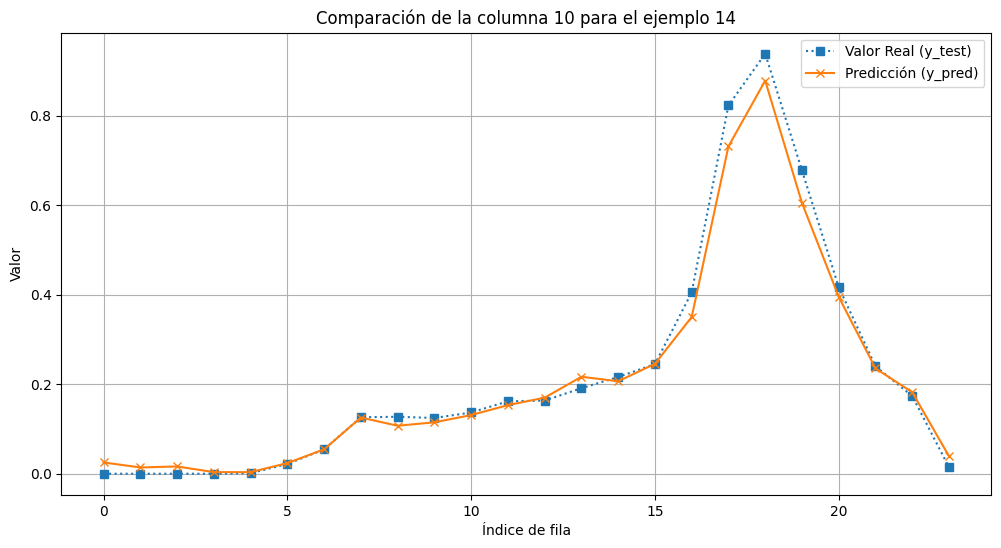

Ejemplo 14 - MAE: 0.0204, MSE: 0.0010


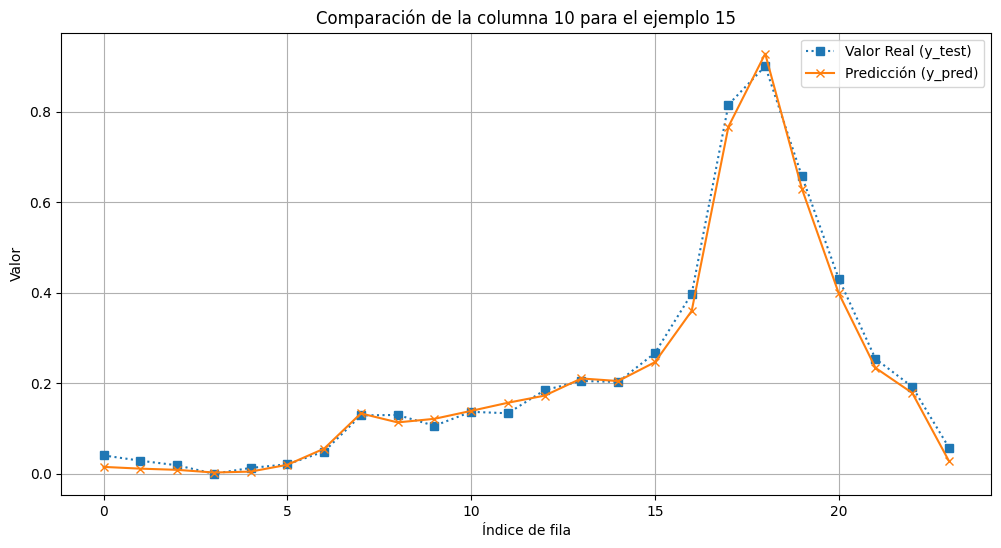

Ejemplo 15 - MAE: 0.0171, MSE: 0.0004


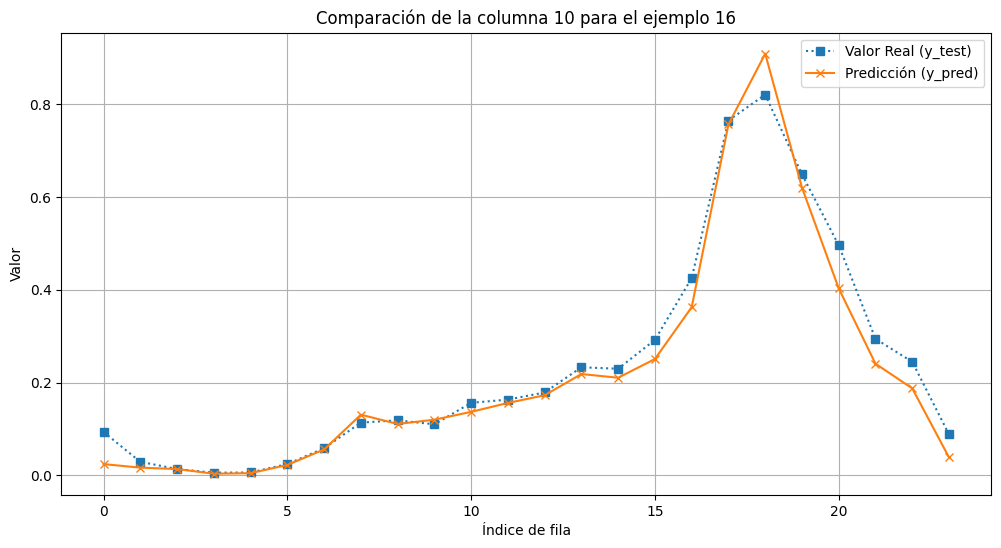

Ejemplo 16 - MAE: 0.0281, MSE: 0.0016


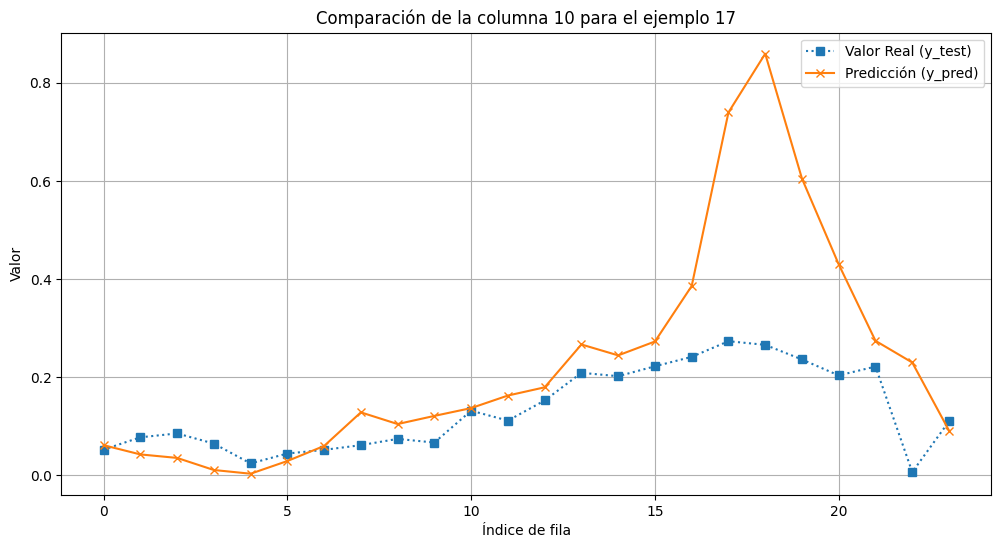

Ejemplo 17 - MAE: 0.1112, MSE: 0.0357


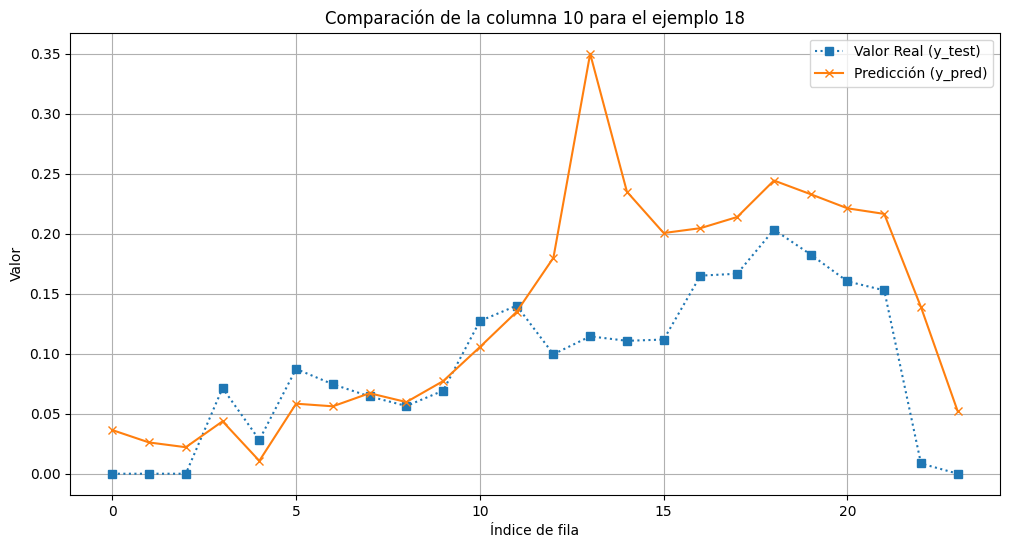

Ejemplo 18 - MAE: 0.0513, MSE: 0.0052

Promedio MAE para la columna 10: 0.0576
Promedio MSE para la columna 10: 0.0147


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dimensiones
M, N = 22, 44

# Seleccionar la columna a comparar
j = 10  # Cambia este valor para seleccionar otra columna

# Verifica que j esté dentro del rango
if j < 0 or j >= N:
    raise ValueError(f"El índice de la columna j debe estar entre 0 y {N - 1}")

mae_list = []
mse_list = []

# Visualizar y calcular métricas para cada ejemplo
for i in range(num_examples):
    plt.figure(figsize=(12, 6))

    # Extraer la columna j para el ejemplo i
    X_example_col = X_example[i, :, j]
    y_test_col = y_test[i, :, j]
    y_pred_col = y_pred[i, :, j]

    x_axis = np.arange(X_example_col.shape[0])

    # Graficar los valores reales (entrada), los valores esperados y las predicciones
    plt.plot(x_axis, y_test_col, label='Valor Real (y_test)', marker='s', linestyle=':')
    plt.plot(x_axis, y_pred_col, label='Predicción (y_pred)', marker='x', linestyle='-')

    plt.title(f'Comparación de la columna {j} para el ejemplo {i+1}')
    plt.xlabel('Índice de fila')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calcular las métricas de error entre y_test y y_pred
    mae = mean_absolute_error(y_test_col, y_pred_col)
    mse = mean_squared_error(y_test_col, y_pred_col)

    mae_list.append(mae)
    mse_list.append(mse)

    # Imprimir las métricas para el ejemplo actual
    print(f'Ejemplo {i+1} - MAE: {mae:.4f}, MSE: {mse:.4f}')

# Calcular y mostrar los promedios de las métricas
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)

print(f'\nPromedio MAE para la columna {j}: {avg_mae:.4f}')
print(f'Promedio MSE para la columna {j}: {avg_mse:.4f}')


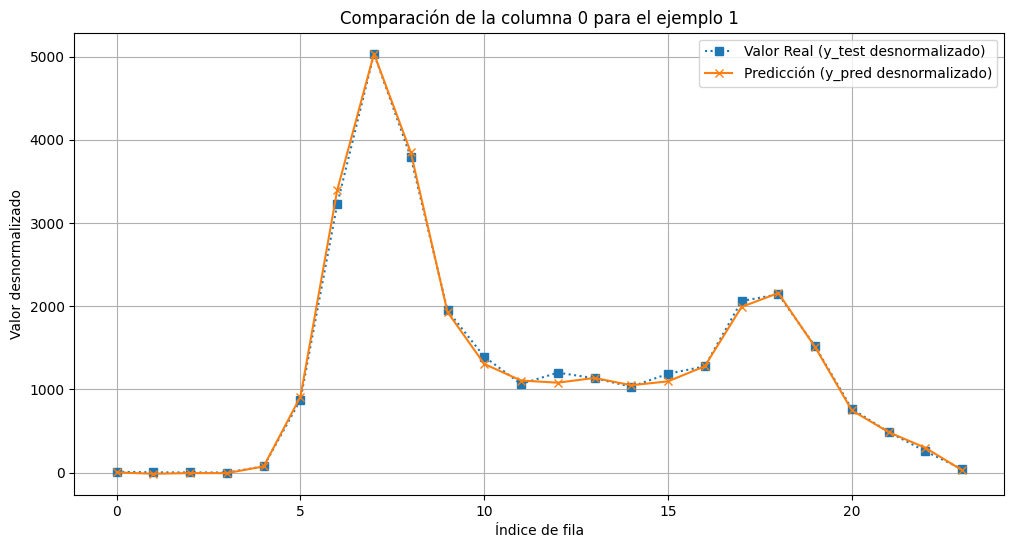

Ejemplo 1 - MAE (desnormalizado): 35.4915, MSE (desnormalizado): 3071.7423
Ejemplo 1 - MAE relativo: 2.79%, MSE relativo: 241.53%


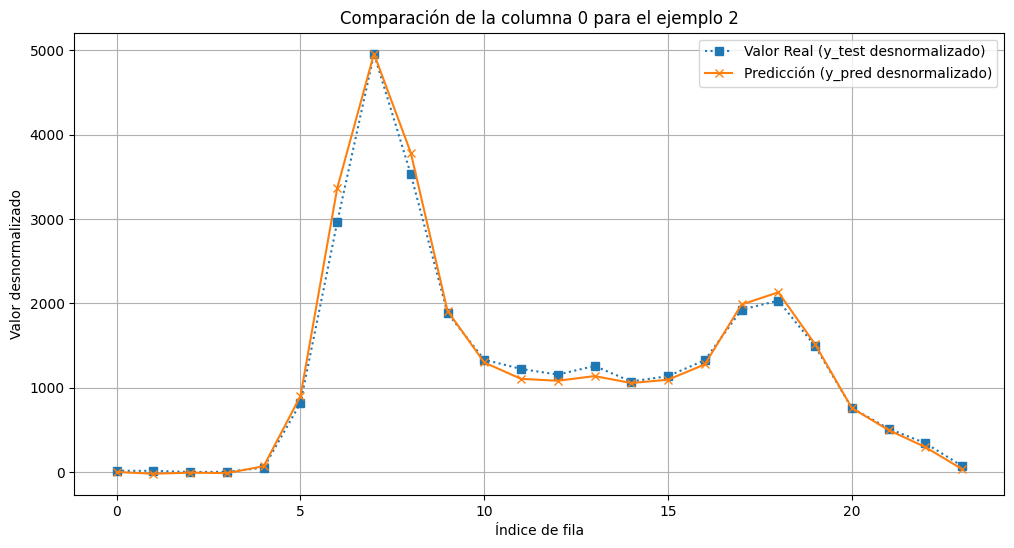

Ejemplo 2 - MAE (desnormalizado): 66.5130, MSE (desnormalizado): 12273.1217
Ejemplo 2 - MAE relativo: 5.34%, MSE relativo: 984.51%


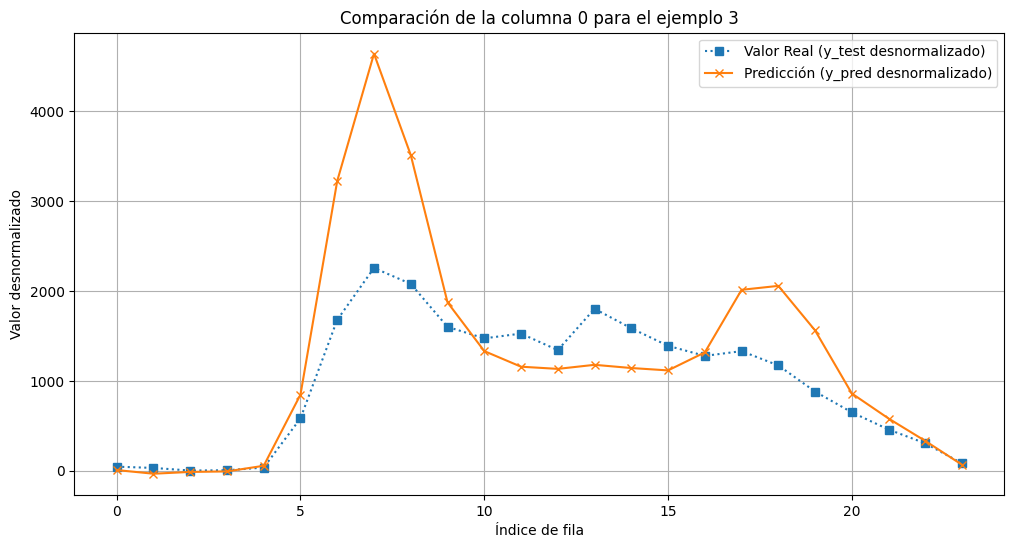

Ejemplo 3 - MAE (desnormalizado): 448.4950, MSE (desnormalizado): 537360.4871
Ejemplo 3 - MAE relativo: 45.62%, MSE relativo: 54653.78%


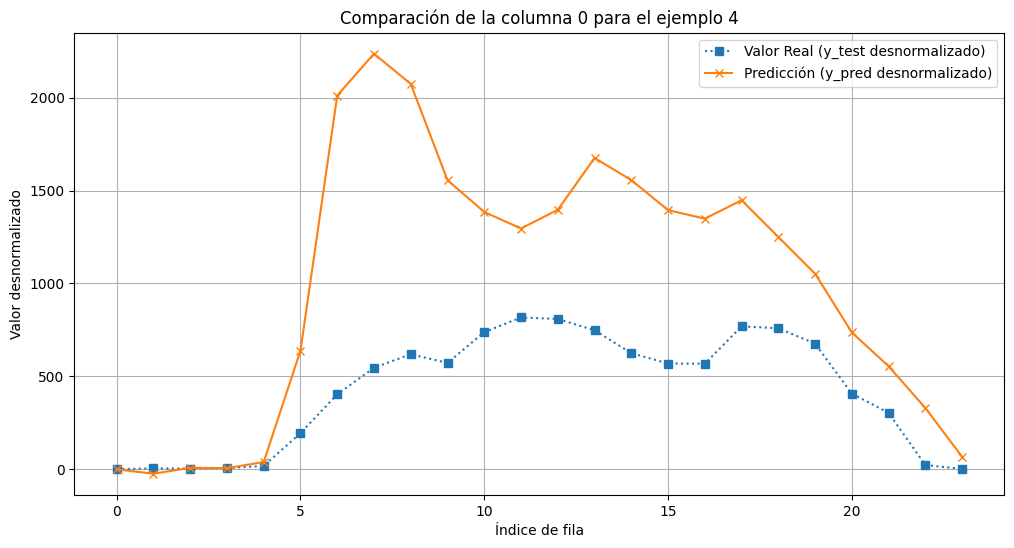

Ejemplo 4 - MAE (desnormalizado): 580.1949, MSE (desnormalizado): 578049.4564
Ejemplo 4 - MAE relativo: 136.85%, MSE relativo: 136345.82%


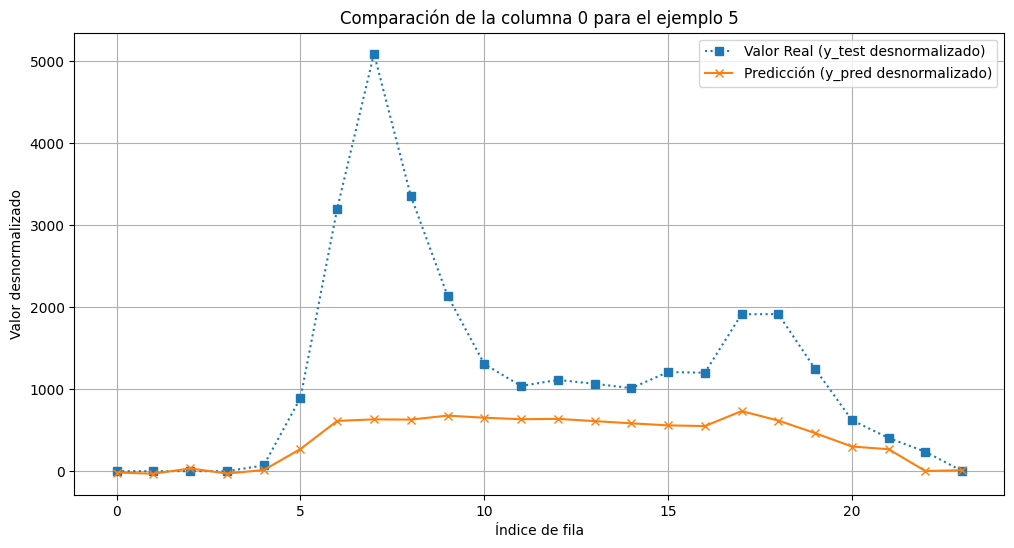

Ejemplo 5 - MAE (desnormalizado): 821.7267, MSE (desnormalizado): 1771733.9733
Ejemplo 5 - MAE relativo: 67.88%, MSE relativo: 146353.74%


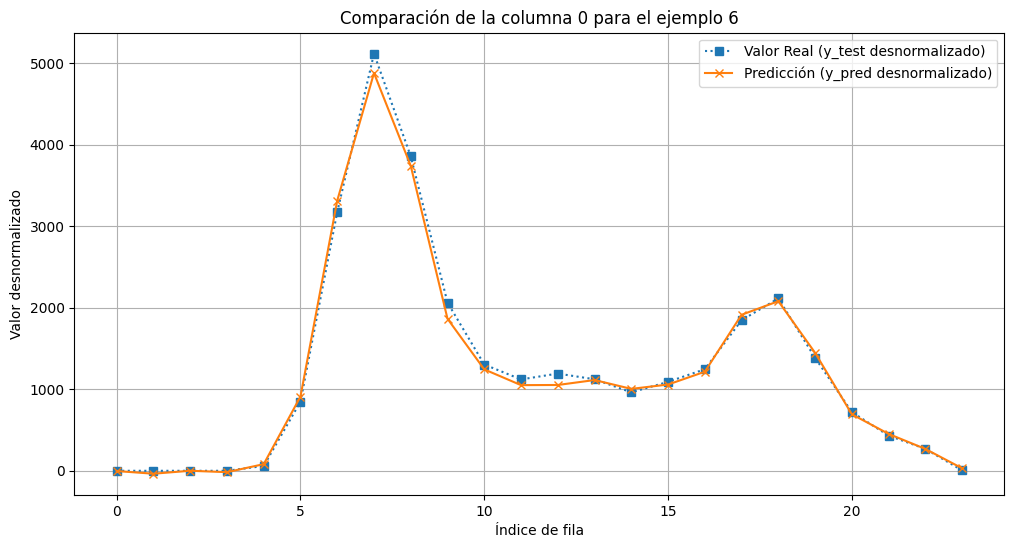

Ejemplo 6 - MAE (desnormalizado): 60.6127, MSE (desnormalizado): 7414.9952
Ejemplo 6 - MAE relativo: 4.86%, MSE relativo: 594.92%


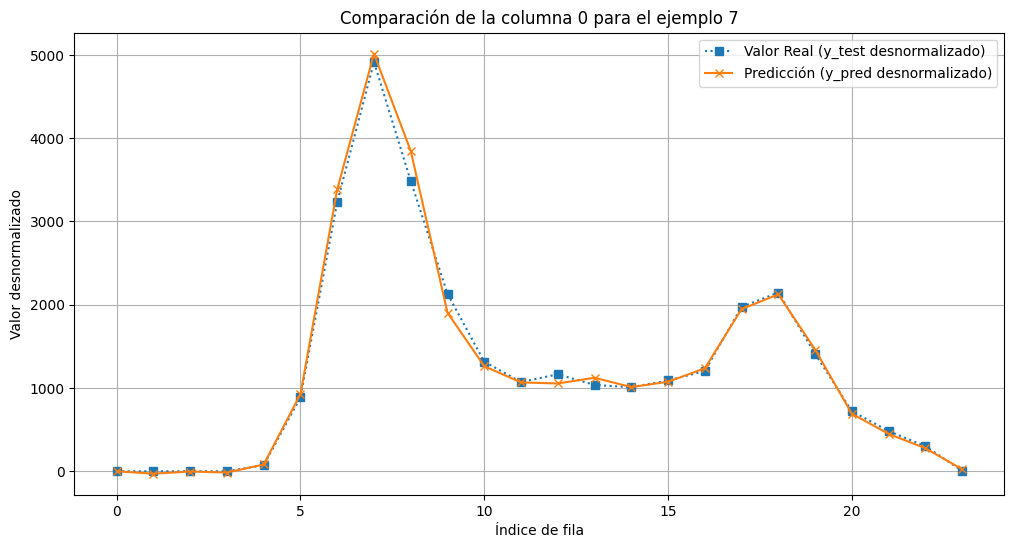

Ejemplo 7 - MAE (desnormalizado): 60.1980, MSE (desnormalizado): 10312.7773
Ejemplo 7 - MAE relativo: 4.87%, MSE relativo: 834.40%


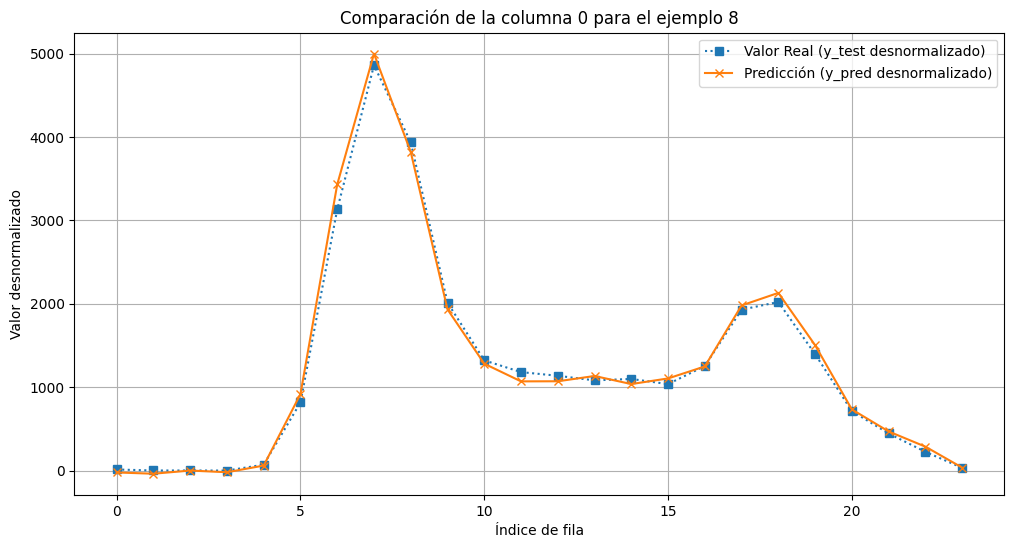

Ejemplo 8 - MAE (desnormalizado): 67.5412, MSE (desnormalizado): 8441.1965
Ejemplo 8 - MAE relativo: 5.45%, MSE relativo: 681.57%


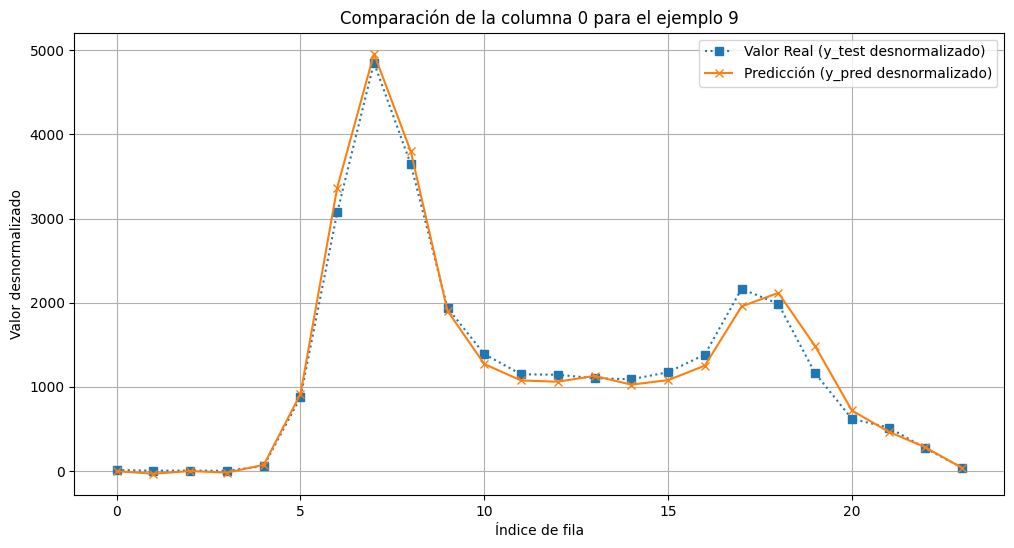

Ejemplo 9 - MAE (desnormalizado): 89.1346, MSE (desnormalizado): 15036.1926
Ejemplo 9 - MAE relativo: 7.21%, MSE relativo: 1216.48%


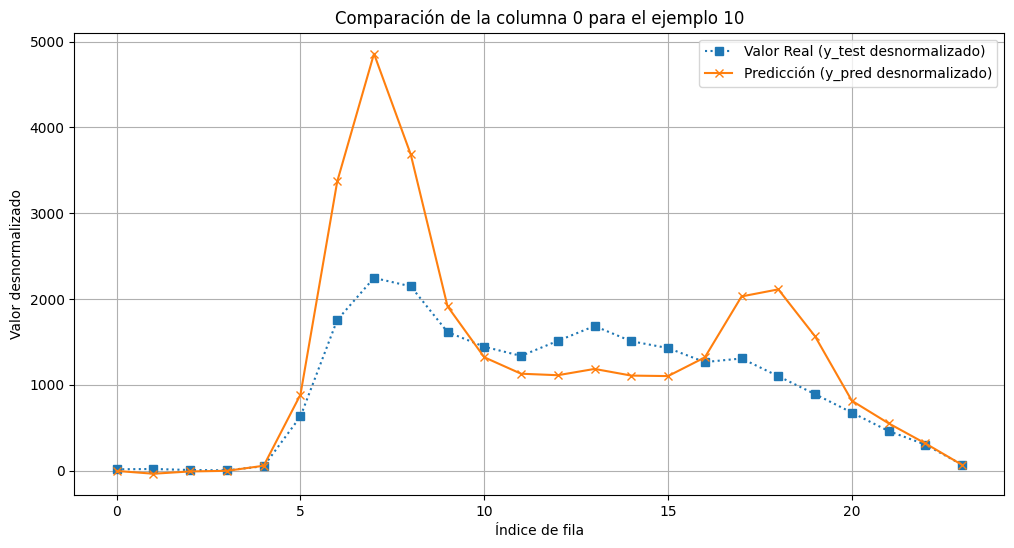

Ejemplo 10 - MAE (desnormalizado): 461.9581, MSE (desnormalizado): 613497.8989
Ejemplo 10 - MAE relativo: 47.23%, MSE relativo: 62719.16%


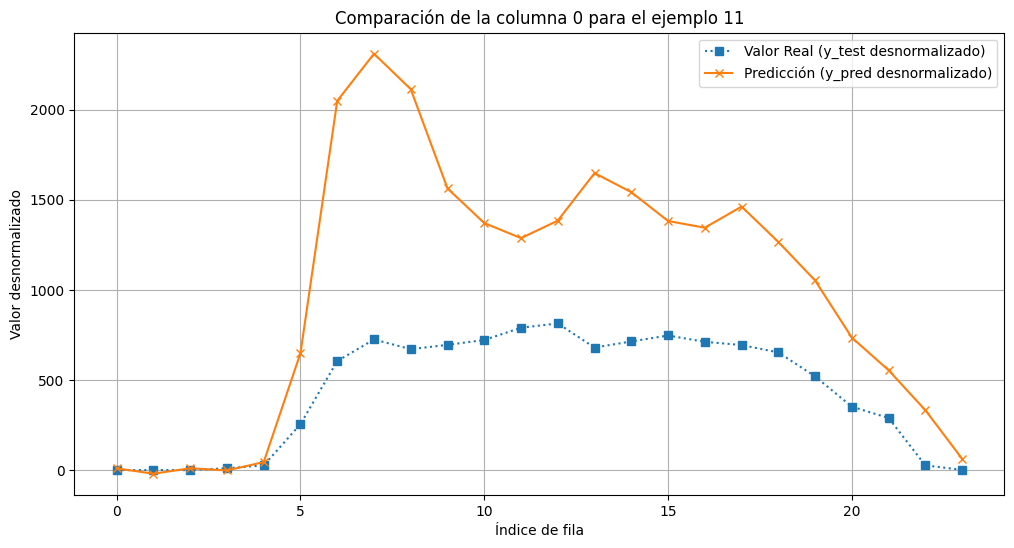

Ejemplo 11 - MAE (desnormalizado): 563.3271, MSE (desnormalizado): 524312.5944
Ejemplo 11 - MAE relativo: 126.34%, MSE relativo: 117591.84%


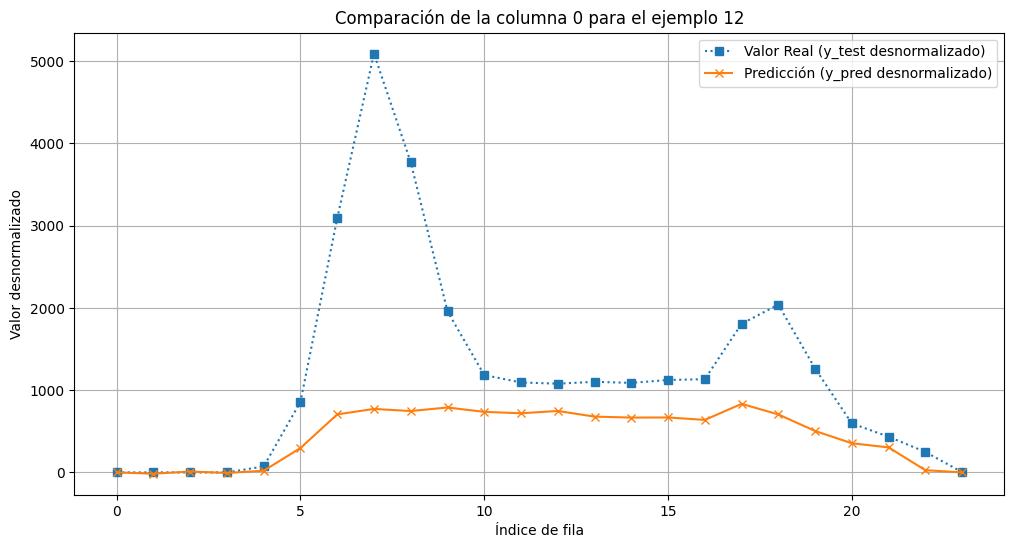

Ejemplo 12 - MAE (desnormalizado): 756.5033, MSE (desnormalizado): 1660651.4770
Ejemplo 12 - MAE relativo: 62.52%, MSE relativo: 137243.92%


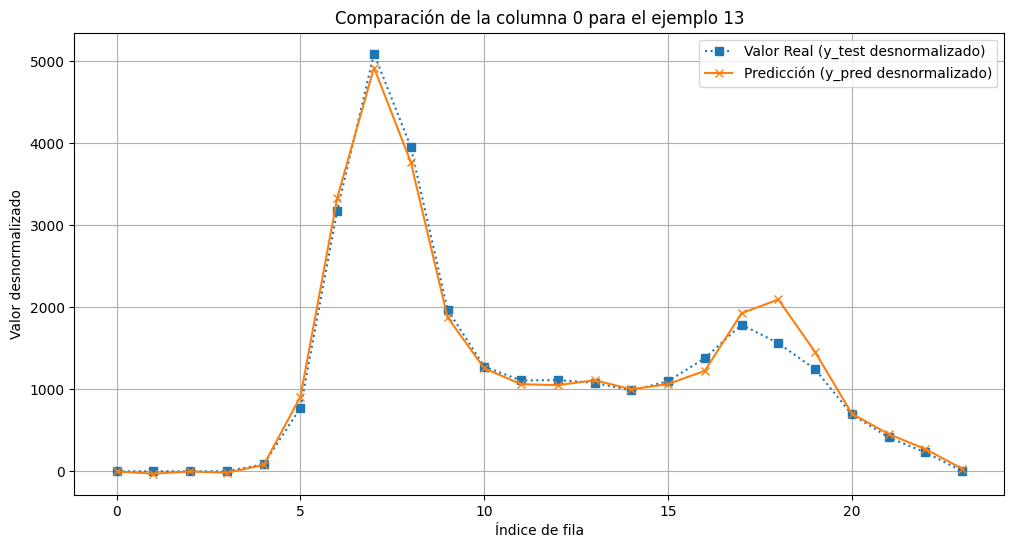

Ejemplo 13 - MAE (desnormalizado): 90.0703, MSE (desnormalizado): 20810.5786
Ejemplo 13 - MAE relativo: 7.44%, MSE relativo: 1719.59%


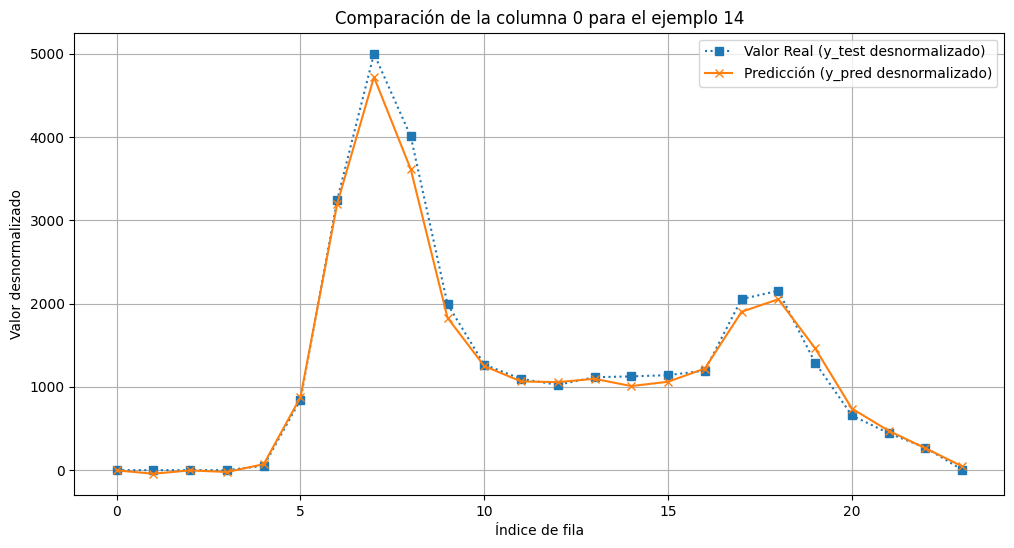

Ejemplo 14 - MAE (desnormalizado): 79.6870, MSE (desnormalizado): 15105.2864
Ejemplo 14 - MAE relativo: 6.38%, MSE relativo: 1208.70%


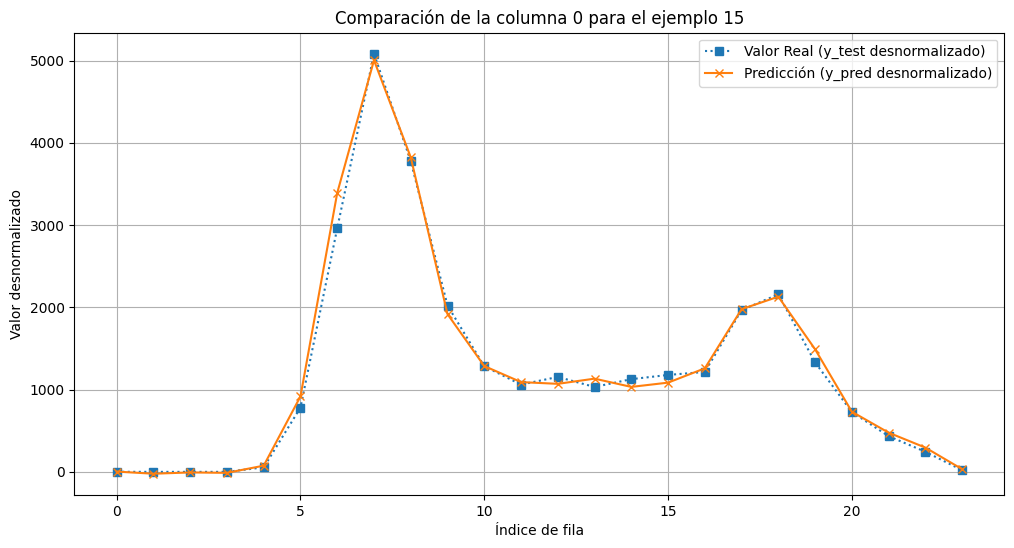

Ejemplo 15 - MAE (desnormalizado): 67.3927, MSE (desnormalizado): 12176.8515
Ejemplo 15 - MAE relativo: 5.46%, MSE relativo: 986.95%


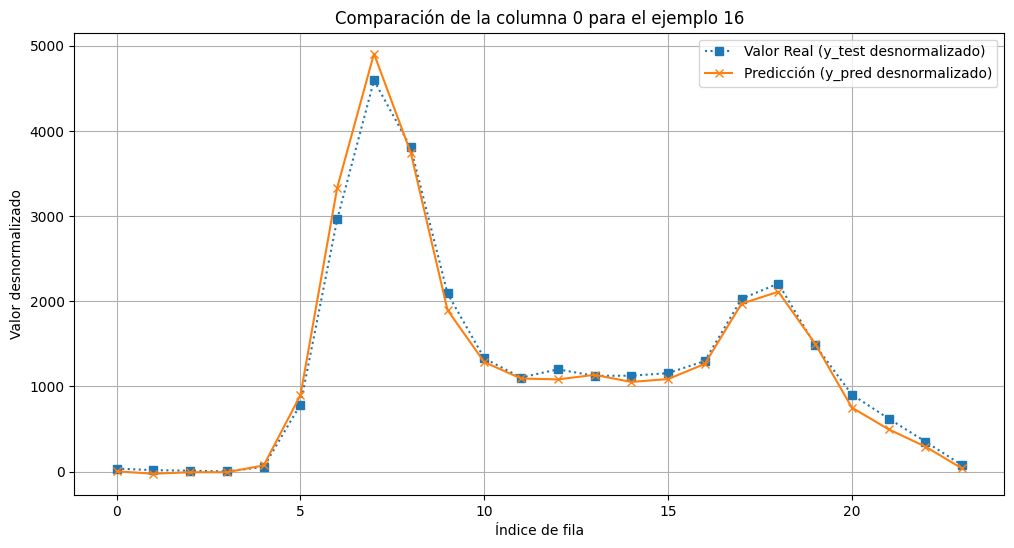

Ejemplo 16 - MAE (desnormalizado): 86.5255, MSE (desnormalizado): 15775.7182
Ejemplo 16 - MAE relativo: 6.83%, MSE relativo: 1246.11%


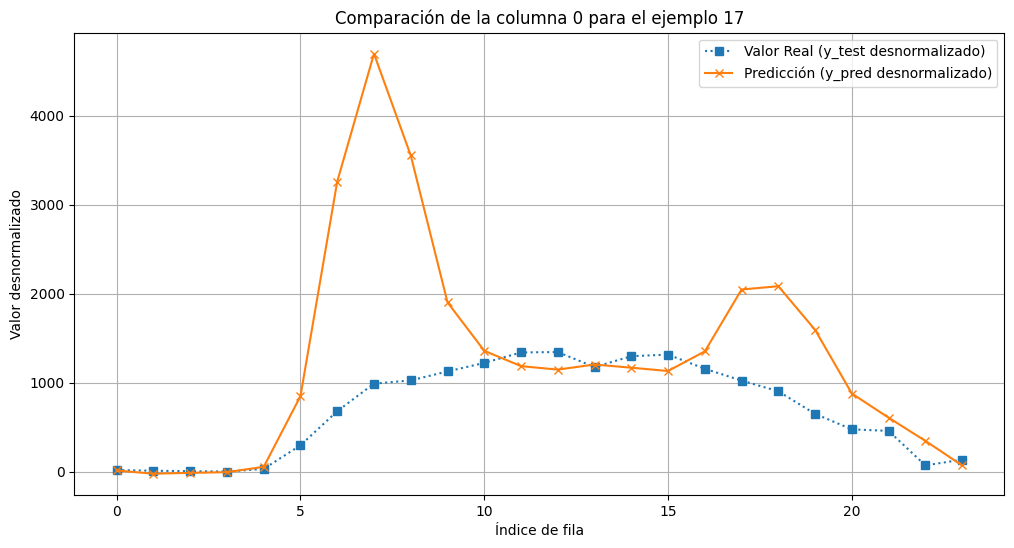

Ejemplo 17 - MAE (desnormalizado): 637.2892, MSE (desnormalizado): 1311174.0953
Ejemplo 17 - MAE relativo: 91.23%, MSE relativo: 187701.63%


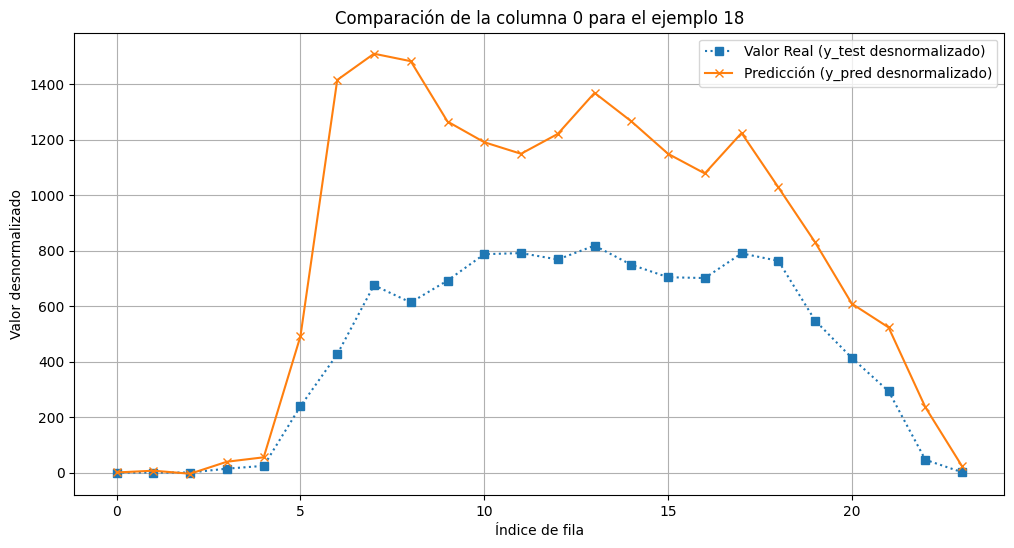

Ejemplo 18 - MAE (desnormalizado): 346.1411, MSE (desnormalizado): 195724.9483
Ejemplo 18 - MAE relativo: 76.53%, MSE relativo: 43274.06%

Promedio MAE (desnormalizado) para la columna 0: 295.4890
Promedio MSE (desnormalizado) para la columna 0: 406273.5217
Promedio MAE relativo para la columna 0: 39.49
Promedio MSE relativo para la columna 0: 49755.48


In [ ]:
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dimensiones
M, N = 22, 44  # Ajusta según tus datos

# Cargar el escalador desde el archivo scaler.pkl
scaler_path = './scaler.pkl'
scaler = load(scaler_path)

# Seleccionar la columna a comparar
j = 0  # Cambia este valor para seleccionar otra columna

# Verifica que j esté dentro del rango
if j < 0 or j >= N:
    raise ValueError(f"El índice de la columna j debe estar entre 0 y {N - 1}")

mae_list = []
mse_list = []
mae_relative_list = []
mse_relative_list = []

# Visualizar y calcular métricas para cada ejemplo
for i in range(num_examples):
    plt.figure(figsize=(12, 6))

    # Extraer una fila completa del ejemplo para respetar la escala
    X_example_row = X_example[i]
    y_test_row = y_test[i]
    y_pred_row = y_pred[i]

    # Desnormalizar las filas completas y luego extraer la columna j
    X_example_denorm = scaler.inverse_transform(X_example_row)
    y_test_denorm = scaler.inverse_transform(y_test_row)
    y_pred_denorm = scaler.inverse_transform(y_pred_row)

    # Extraer la columna j después de la desnormalización
    X_example_col_denorm = X_example_denorm[:, j]
    y_test_col_denorm = y_test_denorm[:, j]
    y_pred_col_denorm = y_pred_denorm[:, j]

    x_axis = np.arange(X_example_col_denorm.shape[0])

    # Graficar los valores desnormalizados
    plt.plot(x_axis, y_test_col_denorm, label='Valor Real (y_test desnormalizado)', marker='s', linestyle=':')
    plt.plot(x_axis, y_pred_col_denorm, label='Predicción (y_pred desnormalizado)', marker='x', linestyle='-')

    plt.title(f'Comparación de la columna {j} para el ejemplo {i+1}')
    plt.xlabel('Índice de fila')
    plt.ylabel('Valor desnormalizado')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calcular las métricas de error entre y_test y y_pred en datos desnormalizados
    mae = mean_absolute_error(y_test_col_denorm, y_pred_col_denorm)
    mse = mean_squared_error(y_test_col_denorm, y_pred_col_denorm)

    # Calcular métricas relativas
    mae_relative = (mae / np.mean(y_test_col_denorm)) * 100
    mse_relative = (mse / np.mean(y_test_col_denorm)) * 100

    mae_list.append(mae)
    mse_list.append(mse)
    mae_relative_list.append(mae_relative)
    mse_relative_list.append(mse_relative)

    # Imprimir las métricas para el ejemplo actual
    print(f'Ejemplo {i+1} - MAE (desnormalizado): {mae:.4f}, MSE (desnormalizado): {mse:.4f}')
    print(f'Ejemplo {i+1} - MAE relativo: {mae_relative:.2f}%, MSE relativo: {mse_relative:.2f}%')

# Calcular y mostrar los promedios de las métricas
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_mae_relative = np.mean(mae_relative_list)
avg_mse_relative = np.mean(mse_relative_list)

print(f'\nPromedio MAE (desnormalizado) para la columna {j}: {avg_mae:.4f}')
print(f'Promedio MSE (desnormalizado) para la columna {j}: {avg_mse:.4f}')
print(f'Promedio MAE relativo para la columna {j}: {avg_mae_relative:.2f}')
print(f'Promedio MSE relativo para la columna {j}: {avg_mse_relative:.2f}')


In [ ]:
from joblib import load
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dimensiones
M, N = 22, 44  # Ajusta según tus datos

# Cargar el escalador desde el archivo scaler.pkl
scaler_path = './scaler.pkl'
scaler = load(scaler_path)

# Verifica que las variables X_example, y_test, y_pred estén definidas
# Si no lo están, tendrás que cargarlas desde los datos correspondientes.

mae_dict_1 = {}  # Para el primer conjunto de ejemplos
mae_dict_2 = {}  # Para el segundo conjunto de ejemplos
mae_dict_3 = {}  # Para el tercer conjunto de ejemplos

mse_dict_1 = {}  # Para el primer conjunto de ejemplos (MSE)
mse_dict_2 = {}  # Para el segundo conjunto de ejemplos (MSE)
mse_dict_3 = {}  # Para el tercer conjunto de ejemplos (MSE)

r2_dict_1 = {}   # Para el primer conjunto de ejemplos (R²)
r2_dict_2 = {}   # Para el segundo conjunto de ejemplos (R²)
r2_dict_3 = {}   # Para el tercer conjunto de ejemplos (R²)

# Selección de ejemplos para los conjuntos
selected_examples_1 = [0]  # Ejemplo 1
selected_examples_2 = [1]  # Ejemplo 2
selected_examples_3 = [3]  # Ejemplo 3

# Calcular métricas para el primer conjunto de ejemplos
for j in range(N):
    mae_list_1 = []
    mse_list_1 = []
    r2_list_1 = []

    for i in selected_examples_1:
        # Extraer una fila completa del ejemplo
        X_example_row = X_example[i]
        y_test_row = y_test[i]
        y_pred_row = y_pred[i]

        # Desnormalizar las filas completas y extraer la columna j
        X_example_denorm = scaler.inverse_transform(X_example_row)
        y_test_denorm = scaler.inverse_transform(y_test_row)
        y_pred_denorm = scaler.inverse_transform(y_pred_row)

        y_test_col_denorm = y_test_denorm[:, j]
        y_pred_col_denorm = y_pred_denorm[:, j]

        # Calcular las métricas de error entre y_test y y_pred
        mae = mean_absolute_error(y_test_col_denorm, y_pred_col_denorm)
        mse = mean_squared_error(y_test_col_denorm, y_pred_col_denorm)
        r2 = r2_score(y_test_col_denorm, y_pred_col_denorm)

        mae_list_1.append(mae)
        mse_list_1.append(mse)
        r2_list_1.append(r2)

    avg_mae_1 = np.mean(mae_list_1)
    avg_mse_1 = np.mean(mse_list_1)
    avg_r2_1 = np.mean(r2_list_1)

    mae_dict_1[j] = avg_mae_1
    mse_dict_1[j] = avg_mse_1
    r2_dict_1[j] = avg_r2_1

# Calcular métricas para el segundo conjunto de ejemplos
for j in range(N):
    mae_list_2 = []
    mse_list_2 = []
    r2_list_2 = []  # Lista para almacenar R²

    for i in selected_examples_2:
        # Extraer una fila completa del ejemplo
        X_example_row = X_example[i]
        y_test_row = y_test[i]
        y_pred_row = y_pred[i]

        # Desnormalizar las filas completas y extraer la columna j
        X_example_denorm = scaler.inverse_transform(X_example_row)
        y_test_denorm = scaler.inverse_transform(y_test_row)
        y_pred_denorm = scaler.inverse_transform(y_pred_row)

        y_test_col_denorm = y_test_denorm[:, j]
        y_pred_col_denorm = y_pred_denorm[:, j]

        # Calcular las métricas de error entre y_test y y_pred
        mae = mean_absolute_error(y_test_col_denorm, y_pred_col_denorm)
        mse = mean_squared_error(y_test_col_denorm, y_pred_col_denorm)
        r2 = r2_score(y_test_col_denorm, y_pred_col_denorm)

        mae_list_2.append(mae)
        mse_list_2.append(mse)
        r2_list_2.append(r2)

    avg_mae_2 = np.mean(mae_list_2)
    avg_mse_2 = np.mean(mse_list_2)
    avg_r2_2 = np.mean(r2_list_2)

    mae_dict_2[j] = avg_mae_2
    mse_dict_2[j] = avg_mse_2
    r2_dict_2[j] = avg_r2_2

# Calcular métricas para el tercer conjunto de ejemplos
for j in range(N):
    mae_list_3 = []
    mse_list_3 = []
    r2_list_3 = []  # Lista para almacenar R²

    for i in selected_examples_3:
        # Extraer una fila completa del ejemplo
        X_example_row = X_example[i]
        y_test_row = y_test[i]
        y_pred_row = y_pred[i]

        # Desnormalizar las filas completas y extraer la columna j
        X_example_denorm = scaler.inverse_transform(X_example_row)
        y_test_denorm = scaler.inverse_transform(y_test_row)
        y_pred_denorm = scaler.inverse_transform(y_pred_row)

        y_test_col_denorm = y_test_denorm[:, j]
        y_pred_col_denorm = y_pred_denorm[:, j]

        # Calcular las métricas de error entre y_test y y_pred
        mae = mean_absolute_error(y_test_col_denorm, y_pred_col_denorm)
        mse = mean_squared_error(y_test_col_denorm, y_pred_col_denorm)
        r2 = r2_score(y_test_col_denorm, y_pred_col_denorm)

        mae_list_3.append(mae)
        mse_list_3.append(mse)
        r2_list_3.append(r2)

    avg_mae_3 = np.mean(mae_list_3)
    avg_mse_3 = np.mean(mse_list_3)
    avg_r2_3 = np.mean(r2_list_3)

    mae_dict_3[j] = avg_mae_3
    mse_dict_3[j] = avg_mse_3
    r2_dict_3[j] = avg_r2_3

# Calcular la media de los promedios MAE, MSE y R² de todas las columnas para cada conjunto
overall_avg_mae_1 = np.mean(list(mae_dict_1.values()))
overall_avg_mse_1 = np.mean(list(mse_dict_1.values()))
overall_avg_r2_1 = np.mean(list(r2_dict_1.values()))

overall_avg_mae_2 = np.mean(list(mae_dict_2.values()))
overall_avg_mse_2 = np.mean(list(mse_dict_2.values()))
overall_avg_r2_2 = np.mean(list(r2_dict_2.values()))

overall_avg_mae_3 = np.mean(list(mae_dict_3.values()))
overall_avg_mse_3 = np.mean(list(mse_dict_3.values()))
overall_avg_r2_3 = np.mean(list(r2_dict_3.values()))

# Imprimir los resultados finales
print(f"\nMedia de los promedios MAE de todas las columnas para el primer conjunto: {overall_avg_mae_1:.4f}")
print(f"Media de los promedios MSE de todas las columnas para el primer conjunto: {overall_avg_mse_1:.4f}")
print(f"Media de los promedios R² de todas las columnas para el primer conjunto: {overall_avg_r2_1:.4f}")

print(f"\nMedia de los promedios MAE de todas las columnas para el segundo conjunto: {overall_avg_mae_2:.4f}")
print(f"Media de los promedios MSE de todas las columnas para el segundo conjunto: {overall_avg_mse_2:.4f}")
print(f"Media de los promedios R² de todas las columnas para el segundo conjunto: {overall_avg_r2_2:.4f}")

print(f"\nMedia de los promedios MAE de todas las columnas para el tercer conjunto: {overall_avg_mae_3:.4f}")
print(f"Media de los promedios MSE de todas las columnas para el tercer conjunto: {overall_avg_mse_3:.4f}")
print(f"Media de los promedios R² de todas las columnas para el tercer conjunto: {overall_avg_r2_3:.4f}")



Media de los promedios MAE de todas las columnas para el primer conjunto: 22.7142
Media de los promedios MSE de todas las columnas para el primer conjunto: 3946.8870
Media de los promedios R² de todas las columnas para el primer conjunto: 0.9544

Media de los promedios MAE de todas las columnas para el segundo conjunto: 32.6131
Media de los promedios MSE de todas las columnas para el segundo conjunto: 6612.5480
Media de los promedios R² de todas las columnas para el segundo conjunto: 0.9481

Media de los promedios MAE de todas las columnas para el tercer conjunto: 181.0161
Media de los promedios MSE de todas las columnas para el tercer conjunto: 201820.5039
Media de los promedios R² de todas las columnas para el tercer conjunto: -8.9201
